In [1]:
import os
os.chdir("../..")

import itertools
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy
from scipy.special import boxcox, inv_boxcox

#!pip install pmdarima
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
import pmdarima as pm
from pmdarima import model_selection
from pmdarima import auto_arima

import warnings
warnings.filterwarnings('ignore')

In [2]:
filedir = os.getcwd() + "/data/tourism/palau/intermediate/"
filepath = filedir + os.listdir(filedir)[0]

## Preprocessing
### Use `stringency_index` as a proxy

In [7]:
covid_data = pd.read_csv(os.getcwd() + "/data/tourism/owid-covid-data.csv")

# There is no Palau's stringency index, using Oceania's mean as the proxy
oceania_covid = (covid_data[covid_data.continent == "Oceania"]
                 .reset_index()
                 .drop("index", axis=1))
oceania_index = oceania_covid[["date", "location", "stringency_index"]]
oceania_index["date"] = pd.to_datetime(oceania_index["date"])
oceania_index = oceania_index.groupby("date").mean().reset_index()
oceania_index.head(5)

,date,stringency_index
0,2020-01-26,5.560
1,2020-01-27,5.560
2,2020-01-28,5.560
3,2020-01-29,5.560
4,2020-01-30,8.335


### Read Palau's intermediate files

In [8]:
palau = pd.read_csv(filepath).drop("Unnamed: 0", axis=1)
palau["Date"] = pd.to_datetime(palau["Date"])
palau = (palau.merge(oceania_index, how="left", left_on="Date", right_on="date")
         .drop("date", axis=1)
         .fillna(0)
         .rename({"stringency_index": "covid"}, axis=1))
palau.head(5)

,Date,JAPAN,SOUTH KOREA,TAIWAN,CHINA,USA/CANADA,EUROPE,OTHERS,Total,covid
0,2007-06-01,856.0,1291.0,3245.0,86.0,669.0,99.0,463.0,6709.0,0.0
1,2007-07-01,2119.0,1366.0,3269.0,33.0,653.0,144.0,437.0,8021.0,0.0
2,2007-08-01,3476.0,1354.0,3046.0,46.0,580.0,256.0,438.0,9196.0,0.0
3,2007-09-01,3022.0,910.0,2497.0,61.0,559.0,145.0,401.0,7595.0,0.0
4,2007-10-01,1807.0,1082.0,2298.0,49.0,774.0,390.0,395.0,6795.0,0.0


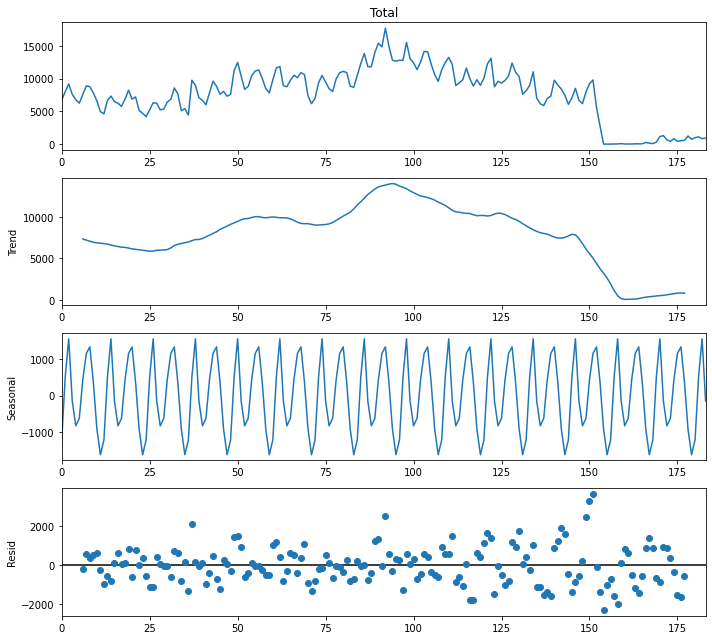

In [10]:
decompose = seasonal_decompose(palau["Total"], period=12, model="additive")
f = decompose.plot()
plt.rcParams.update({'figure.figsize': (10, 9)})

## SARIMAX

### Train-Test Split

In [11]:
# Use 90% of the data as the training data
size = len(palau)
train_size = round(0.9*size, 0)
train, test = model_selection.train_test_split(
    palau[["Date", "Total", "covid"]], train_size=165)

### Stepwise searching

In [12]:
stepwise_fit = auto_arima(train["Total"], start_p=1, start_q=1,
                          max_p=5, max_q=5, m=12,
                          start_P=0, seasonal=True,
                          d=0, D=1, trace=True,
                          error_action='ignore',  # don't want to know if an order does not work
                          suppress_warnings=True,  # don't want convergence warnings
                          stepwise=True)  # set to stepwise

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=2638.685, Time=0.40 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=2882.120, Time=0.01 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=2663.036, Time=0.15 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=2780.658, Time=0.15 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=2885.637, Time=0.01 sec
 ARIMA(1,0,1)(0,1,0)[12] intercept   : AIC=2693.408, Time=0.06 sec
 ARIMA(1,0,1)(1,1,1)[12] intercept   : AIC=inf, Time=0.47 sec
 ARIMA(1,0,1)(0,1,2)[12] intercept   : AIC=2633.088, Time=1.21 sec
 ARIMA(1,0,1)(1,1,2)[12] intercept   : AIC=inf, Time=1.37 sec
 ARIMA(0,0,1)(0,1,2)[12] intercept   : AIC=2782.455, Time=1.99 sec
 ARIMA(1,0,0)(0,1,2)[12] intercept   : AIC=inf, Time=1.33 sec
 ARIMA(2,0,1)(0,1,2)[12] intercept   : AIC=inf, Time=1.32 sec
 ARIMA(1,0,2)(0,1,2)[12] intercept   : AIC=2641.248, Time=1.74 sec
 ARIMA(0,0,0)(0,1,2)[12] intercept   : AIC=2885.512, Time=0.43 sec
 ARIMA(0,0,2)(0,1,2)[12] intercept   : 

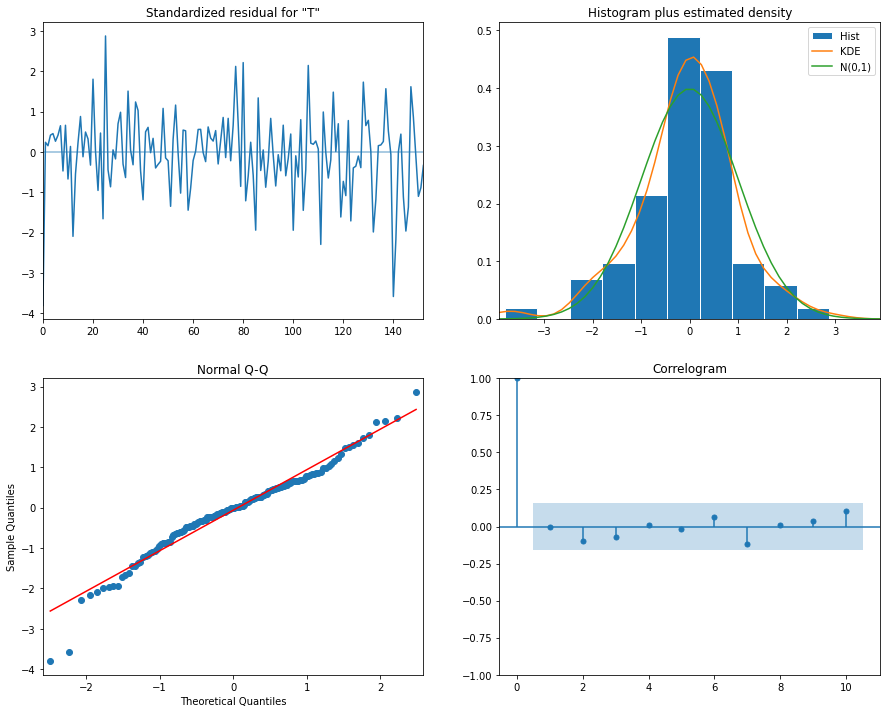

Ljung-box p-values:
[0.99920768 0.45635024 0.50071505 0.66538672 0.78595318 0.80263719
 0.6144054  0.71592945 0.77520149 0.68357311 0.74159533 0.71403528
 0.76386112 0.81939189 0.82118373 0.86417649 0.86461221 0.89524134
 0.75993699 0.78857658 0.802756   0.84052132 0.87551896 0.89694337]


<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                       
=============================================================================================
Dep. Variable:                                 Total   No. Observations:                  165
Model:             ARIMA(1, 0, 1)x(0, 1, [1, 2], 12)   Log Likelihood               -1308.019
Date:                               Thu, 23 Feb 2023   AIC                           2628.038
Time:                                       15:41:07   BIC                           2646.220
Sample:                                            0   HQIC                          2635.424
                                               - 165                                         
Covariance Type:                                 opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
covid        -32.2865     23.078     -1.399      0.162     -77.518      12.946
ar.L1          0.9997      0.010     98.713      0.000       0.980       1.020
ma.L1         -0.2206      0.078     -2.818      0.005      -0.374      -0.067
ma.S.L12      -1.0104      0.111     -9.121      0.000      -1.228      -0.793
ma.S.L24       0.0159      0.079      0.203      0.839      -0.138       0.170
sigma2      1.304e+06   7.16e-05   1.82e+10      0.000     1.3e+06     1.3e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                24.03
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.37   Skew:                            -0.50
Prob(H) (two-sided):                  0.27   Kurtosis:                         4.67
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 6.44e+26. Standard errors may be unstable.
"""

In [14]:
# Use the best model from the stepwise searching
arma_mod = ARIMA(train["Total"], exog=train["covid"],
                 order=(1, 0, 1), seasonal_order=(0, 1, 2, 12))
arma_res = arma_mod.fit()
arma_res.plot_diagnostics(figsize=(15, 12))

plt.show()
print("Ljung-box p-values:\n" +
      str(arma_res.test_serial_correlation(method='ljungbox')[0][1]))
arma_res.summary()

In [16]:
def sarimax(series, exog, all_param):
    results = []
    for param in all_param:
        try:
            mod = SARIMAX(series,
                          exog=exog,
                          order=param[0],
                          seasonal_order=param[1],
                          return_ssm=False)
            res = mod.fit()
            results.append((res, res.aic, param))
            print(
                'Tried out SARIMAX{}x{} - AIC:{}'.format(param[0], param[1], round(res.aic, 2)))
        except Exception as e:
            print(e)
            continue
    return results

In [17]:
## Set parameter range
p, d, q = range(0, 3), range(0, 2), range(0, 3)
P, D, Q, s = range(0, 3), range(0, 2), range(0, 3), [12]

## list of all parameter combos
pdq = list(itertools.product(p, d, q))
seasonal_pdq = list(itertools.product(P, D, Q, s))
all_param = list(itertools.product(pdq, seasonal_pdq))

## Search the minimim aic 
all_res = sarimax(train["Total"], train["covid"], all_param)
all_res.sort(key=lambda x: x[1])

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.26031D+01    |proj g|=  8.40039D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      0      1      0     0     0   8.400D-06   1.260D+01
  F =   12.603126778130354     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Tried out SARIMAX(0, 0, 0)x(0, 0, 0, 12) - AIC:4163.03
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variable

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  1.02667D+01    |proj g|=  9.12752D-03

At iterate   20    f=  1.02595D+01    |proj g|=  1.49273D-02

At iterate   25    f=  1.02581D+01    |proj g|=  8.09036D-05

At iterate   30    f=  1.02580D+01    |proj g|=  2.55695D-03

At iterate   35    f=  1.02552D+01    |proj g|=  1.61815D-02

At iterate   40    f=  1.01063D+01    |proj g|=  1.25494D-01

At iterate   45    f=  9.80606D+00    |proj g|=  1.49957D-02

At iterate   50    f=  9.77976D+00    |proj g|=  2.67663D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     50     67      1     0     0   2.677D-03   9.780D+00
  F =   9.77976126445

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  8.46903D+00    |proj g|=  2.18235D-04

At iterate   10    f=  8.46896D+00    |proj g|=  9.19674D-03

At iterate   15    f=  8.46823D+00    |proj g|=  9.09206D-03

At iterate   20    f=  8.46815D+00    |proj g|=  6.30064D-04

At iterate   25    f=  8.46563D+00    |proj g|=  2.30467D-02

At iterate   30    f=  8.44157D+00    |proj g|=  7.67481D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     33     40      1     0     0   4.395D-06   8.442D+00
  F =   8.4415684670071087     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Tried out SARIMAX(0, 0, 0)x(0, 1, 2, 12) - AIC:2793

 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     48     63      1     0     0   2.949D-08   9.202D+00
  F =   9.2023810766693792     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Tried out SARIMAX(0, 0, 0)x(1, 0, 1, 12) - AIC:3044.79
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.77206D+00    |proj g|=  8.63529D-01

At iterate    5    f=  9.49927D+00    |proj g|=  2.17276D-03

At iterate   10    f=  9.49824D+00    |proj g|=  1.99069D-02

At iterate   1

 This problem is unconstrained.



At iterate   30    f=  9.35137D+00    |proj g|=  3.27083D-03

At iterate   35    f=  9.35068D+00    |proj g|=  1.02335D-02

At iterate   40    f=  9.34973D+00    |proj g|=  8.08815D-03

At iterate   45    f=  9.31481D+00    |proj g|=  1.15893D-01

At iterate   50    f=  9.19459D+00    |proj g|=  1.27359D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     58      1     0     0   1.274D-02   9.195D+00
  F =   9.1945867682660190     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Tried out SARIMAX(0, 0, 0)x(1, 0, 2, 12) - AIC:3044.21
RUNNING THE L-BFGS-B CODE

           * * *

Machine preci

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  8.45074D+00    |proj g|=  1.11857D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      6     10      1     0     0   1.119D-04   8.451D+00
  F =   8.4507364077660263     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Tried out SARIMAX(0, 0, 0)x(1, 1, 1, 12) - AIC:2796.74
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.46755D+00    |proj g|=  1.08826D-01

At iterate    5    f=  8.45860D+00    |proj g|=  5.10227D-02

At iterate   1

 This problem is unconstrained.


Tried out SARIMAX(0, 0, 0)x(2, 0, 0, 12) - AIC:3045.19
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.48504D+00    |proj g|=  5.24902D-02

At iterate    5    f=  9.48278D+00    |proj g|=  4.69462D-03

At iterate   10    f=  9.38628D+00    |proj g|=  1.46832D-02

At iterate   15    f=  9.33124D+00    |proj g|=  6.09110D-03

At iterate   20    f=  9.31584D+00    |proj g|=  2.52422D-04

At iterate   25    f=  9.29308D+00    |proj g|=  1.95201D-03


 This problem is unconstrained.


  ys=-2.047E-01  -gs= 2.450E-02 BFGS update SKIPPED

At iterate   30    f=  9.26958D+00    |proj g|=  1.10144D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     33     79      1     1     0   1.064D-03   9.260D+00
  F =   9.2596977042180697     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


Tried out SARIMAX(0, 0, 0)x(2, 0, 1, 12) - AIC:3065.7
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.77045D+00    |proj g|=  8.59744D-01

At iterate    5    f=  9.49983D+00    |proj g|=  6.74335D-03

At iterate   10    f=  9.49916D+00    |proj g|=  4.43371D-03

At iterate   15    f=  9.47214D+00    |proj g|=  1.63650D-02

At iterate   20    f=  9.47086D+00    |proj g|=  8.07808D-03

At iterate   25    f=  9.44761D+00    |proj g|=  1.15455D-01

At iterate   30    f=  9.35579D+00    |proj g|=  3.94572D-02

At iterate   35    f=  9.35080D+00    |proj g|=  1.71106D-02

At iterate   40    f=  9.34658D+00    |proj g|=  6.94994D-03

At iterate   45    f=  9.34553D+00    |proj g|=  1.37114D-03

At iterate   50    f=  9.34552D+00    |proj g|=  4.52246D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluation

 This problem is unconstrained.



At iterate   15    f=  8.43611D+00    |proj g|=  4.75625D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     17     20      1     0     0   5.419D-05   8.436D+00
  F =   8.4361122862215385     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Tried out SARIMAX(0, 0, 0)x(2, 1, 0, 12) - AIC:2791.92
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.44642D+00    |proj g|=  1.86642D-01

At iterate    5    f=  8.43216D+00    |proj g|=  3.84285D-02

At iterate   1

 This problem is unconstrained.



At iterate   20    f=  8.42248D+00    |proj g|=  6.27382D-03

At iterate   25    f=  8.42147D+00    |proj g|=  5.78039D-03

At iterate   30    f=  8.42128D+00    |proj g|=  8.24139D-05

At iterate   35    f=  8.42112D+00    |proj g|=  2.04685D-02

At iterate   40    f=  8.41192D+00    |proj g|=  7.07676D-02

At iterate   45    f=  8.40909D+00    |proj g|=  6.29423D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     48     54      1     0     0   2.624D-07   8.409D+00
  F =   8.4090920163886089     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Tried out SARIMAX(0, 0, 0)x(2, 1, 1, 12) - AIC:2785

 This problem is unconstrained.



At iterate   15    f=  8.42882D+00    |proj g|=  5.89907D-03

At iterate   20    f=  8.42881D+00    |proj g|=  5.58215D-04

At iterate   25    f=  8.42879D+00    |proj g|=  1.70375D-02

At iterate   30    f=  8.42739D+00    |proj g|=  5.17008D-02

At iterate   35    f=  8.42701D+00    |proj g|=  4.22655D-03

At iterate   40    f=  8.42698D+00    |proj g|=  1.29609D-04

At iterate   45    f=  8.42698D+00    |proj g|=  6.11372D-03

At iterate   50    f=  8.42364D+00    |proj g|=  6.77942D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     57      1     0     0   6.779D-02   8.424D+00
  F =   8.42364354812

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   45    f=  9.49862D+00    |proj g|=  1.03503D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     48     79      1     0     0   5.508D-07   9.499D+00
  F =   9.4986148371648884     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Tried out SARIMAX(0, 0, 1)x(0, 0, 1, 12) - AIC:3142.54
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.02168D+01    |proj g|=  2.63351D-01

At iterate    5    f=  1.01132D+01    |proj g|=  5.00496D-03

At iterate   1

 This problem is unconstrained.



At iterate   30    f=  1.00891D+01    |proj g|=  8.72480D-04

At iterate   35    f=  1.00863D+01    |proj g|=  1.58840D-02

At iterate   40    f=  9.93213D+00    |proj g|=  7.28843D-02

At iterate   45    f=  9.41839D+00    |proj g|=  1.17035D-01

At iterate   50    f=  9.40283D+00    |proj g|=  3.03833D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     74      1     0     0   3.038D-03   9.403D+00
  F =   9.4028291958752774     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Tried out SARIMAX(0, 0, 1)x(0, 0, 2, 12) - AIC:3112.93
RUNNING THE L-BFGS-B CODE

           * * *

Machine preci

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   30    f=  8.20097D+00    |proj g|=  7.26270D-02

At iterate   35    f=  8.19618D+00    |proj g|=  5.80637D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     39     43      1     0     0   5.876D-07   8.196D+00
  F =   8.1961804452715832     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Tried out SARIMAX(0, 0, 1)x(0, 1, 1, 12) - AIC:2712.74
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.24500D+00    |proj g|=  1.35800D-01

At iterate    

 This problem is unconstrained.



At iterate   15    f=  8.22431D+00    |proj g|=  1.56908D-02

At iterate   20    f=  8.21581D+00    |proj g|=  2.86135D-02

At iterate   25    f=  8.21505D+00    |proj g|=  1.77533D-03

At iterate   30    f=  8.21392D+00    |proj g|=  2.70595D-02

At iterate   35    f=  8.19797D+00    |proj g|=  3.65804D-02

At iterate   40    f=  8.19546D+00    |proj g|=  6.71094D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     42     46      1     0     0   1.255D-05   8.195D+00
  F =   8.1954553884224630     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Tried out SARIMAX(0, 0, 1)x(0, 1, 2, 12) - AIC:2714

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  1.00931D+01    |proj g|=  1.01696D-04

At iterate   15    f=  1.00919D+01    |proj g|=  9.15483D-03

At iterate   20    f=  1.00726D+01    |proj g|=  1.65956D-02

At iterate   25    f=  1.00705D+01    |proj g|=  1.06736D-04

At iterate   30    f=  1.00702D+01    |proj g|=  2.31879D-03

At iterate   35    f=  1.00329D+01    |proj g|=  1.04004D-02

At iterate   40    f=  9.54911D+00    |proj g|=  6.27542D-02

At iterate   45    f=  9.13196D+00    |proj g|=  1.48938D-01

At iterate   50    f=  9.05775D+00    |proj g|=  2.48172D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     70   

 This problem is unconstrained.



At iterate    5    f=  1.00948D+01    |proj g|=  5.75586D-03

At iterate   10    f=  1.00930D+01    |proj g|=  1.33729D-03

At iterate   15    f=  1.00929D+01    |proj g|=  2.54571D-04

At iterate   20    f=  1.00926D+01    |proj g|=  8.10534D-03

At iterate   25    f=  1.00815D+01    |proj g|=  4.77717D-02

At iterate   30    f=  1.00705D+01    |proj g|=  1.94112D-03

At iterate   35    f=  1.00703D+01    |proj g|=  2.10993D-04

At iterate   40    f=  1.00687D+01    |proj g|=  4.76040D-03

At iterate   45    f=  9.95882D+00    |proj g|=  2.21053D-01

At iterate   50    f=  9.41685D+00    |proj g|=  4.08837D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  8.23010D+00    |proj g|=  6.64504D-03

At iterate   15    f=  8.22857D+00    |proj g|=  2.35817D-02

At iterate   20    f=  8.22818D+00    |proj g|=  1.90839D-04

At iterate   25    f=  8.22788D+00    |proj g|=  7.48300D-03

At iterate   30    f=  8.21690D+00    |proj g|=  6.01655D-02

At iterate   35    f=  8.20346D+00    |proj g|=  1.91686D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     37     41      1     0     0   1.242D-06   8.203D+00
  F =   8.2034564143258351     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Tried out SARIMAX(0, 0, 1)x(1, 1, 0, 12) - AIC:2715

 This problem is unconstrained.



At iterate   15    f=  8.21379D+00    |proj g|=  4.57185D-04

At iterate   20    f=  8.21324D+00    |proj g|=  8.53237D-03

At iterate   25    f=  8.20391D+00    |proj g|=  4.08224D-03

At iterate   30    f=  8.20064D+00    |proj g|=  3.34572D-03

At iterate   35    f=  8.19771D+00    |proj g|=  3.71415D-02

At iterate   40    f=  8.19489D+00    |proj g|=  2.18044D-03

At iterate   45    f=  8.19485D+00    |proj g|=  2.60386D-03

At iterate   50    f=  8.19277D+00    |proj g|=  2.85437D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     68      1     0     0   2.854D-02   8.193D+00
  F =   8.19276726787

 This problem is unconstrained.



At iterate   35    f=  1.00620D+01    |proj g|=  8.61709D-03

At iterate   40    f=  9.74720D+00    |proj g|=  1.01267D-01

At iterate   45    f=  9.45650D+00    |proj g|=  6.35255D-02

At iterate   50    f=  9.38108D+00    |proj g|=  1.16265D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     65      1     0     0   1.163D-02   9.381D+00
  F =   9.3810757433526195     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Tried out SARIMAX(0, 0, 1)x(2, 0, 0, 12) - AIC:3105.75
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0

 This problem is unconstrained.



At iterate   10    f=  1.00931D+01    |proj g|=  1.66098D-03

At iterate   15    f=  1.00930D+01    |proj g|=  1.66787D-04

At iterate   20    f=  1.00929D+01    |proj g|=  4.37714D-03

At iterate   25    f=  1.00852D+01    |proj g|=  2.36251D-02

At iterate   30    f=  1.00760D+01    |proj g|=  1.53617D-03

At iterate   35    f=  1.00758D+01    |proj g|=  7.15918D-03

At iterate   40    f=  1.00718D+01    |proj g|=  9.61402D-03

At iterate   45    f=  1.00701D+01    |proj g|=  1.54814D-03

At iterate   50    f=  1.00701D+01    |proj g|=  2.38639D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     62   

 This problem is unconstrained.



At iterate   10    f=  1.00930D+01    |proj g|=  1.09312D-04

At iterate   15    f=  1.00929D+01    |proj g|=  1.51686D-03

At iterate   20    f=  1.00926D+01    |proj g|=  8.83460D-04

At iterate   25    f=  1.00925D+01    |proj g|=  9.85104D-04

At iterate   30    f=  1.00924D+01    |proj g|=  1.83523D-03

At iterate   35    f=  1.00920D+01    |proj g|=  6.41805D-03

At iterate   40    f=  1.00762D+01    |proj g|=  1.07572D-02

At iterate   45    f=  1.00707D+01    |proj g|=  1.07170D-04

At iterate   50    f=  1.00678D+01    |proj g|=  7.52190D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     64   

 This problem is unconstrained.



At iterate   15    f=  8.21590D+00    |proj g|=  2.25833D-02

At iterate   20    f=  8.19896D+00    |proj g|=  6.75391D-02

At iterate   25    f=  8.19613D+00    |proj g|=  6.50941D-04

At iterate   30    f=  8.19586D+00    |proj g|=  1.34819D-02

At iterate   35    f=  8.18476D+00    |proj g|=  5.08433D-02

At iterate   40    f=  8.18196D+00    |proj g|=  2.27905D-04

At iterate   45    f=  8.18196D+00    |proj g|=  5.57440D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     46     49      1     0     0   6.505D-06   8.182D+00
  F =   8.1819589387684832     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL  

 This problem is unconstrained.



At iterate   15    f=  8.21052D+00    |proj g|=  1.63232D-04

At iterate   20    f=  8.21051D+00    |proj g|=  1.85213D-03

At iterate   25    f=  8.20954D+00    |proj g|=  2.63396D-02

At iterate   30    f=  8.18210D+00    |proj g|=  1.07936D-01

At iterate   35    f=  8.17489D+00    |proj g|=  7.72109D-04

At iterate   40    f=  8.17485D+00    |proj g|=  3.64728D-03

At iterate   45    f=  8.17236D+00    |proj g|=  2.58172D-02

At iterate   50    f=  8.17095D+00    |proj g|=  5.75756D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     56      1     0     0   5.758D-04   8.171D+00
  F =   8.17095194258

 This problem is unconstrained.



At iterate   10    f=  8.20286D+00    |proj g|=  2.32691D-02

At iterate   15    f=  8.20125D+00    |proj g|=  3.30217D-04

At iterate   20    f=  8.20124D+00    |proj g|=  1.82691D-03

At iterate   25    f=  8.20102D+00    |proj g|=  7.46940D-03

At iterate   30    f=  8.19786D+00    |proj g|=  9.18671D-03

At iterate   35    f=  8.19770D+00    |proj g|=  1.72198D-04

At iterate   40    f=  8.19762D+00    |proj g|=  6.08256D-03

At iterate   45    f=  8.19628D+00    |proj g|=  2.75311D-02

At iterate   50    f=  8.16016D+00    |proj g|=  9.88900D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     59   

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   30    f=  1.00946D+01    |proj g|=  9.24918D-04

At iterate   35    f=  1.00927D+01    |proj g|=  8.06573D-03

At iterate   40    f=  1.00634D+01    |proj g|=  1.28450D-02

At iterate   45    f=  1.00626D+01    |proj g|=  1.30052D-02
  ys=-3.043E-02  -gs= 3.389E-03 BFGS update SKIPPED

At iterate   50    f=  1.00112D+01    |proj g|=  2.15698D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     75      1     1     0   2.157D-02   1.001D+01
  F =   10.011196483920402     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Tried out SARIMAX(0, 0, 2)x(0, 0, 1, 12) - AIC:3313.69
RUNNIN

 This problem is unconstrained.



At iterate   10    f=  1.00901D+01    |proj g|=  5.96407D-03

At iterate   15    f=  1.00893D+01    |proj g|=  1.01366D-04

At iterate   20    f=  1.00892D+01    |proj g|=  2.25603D-03

At iterate   25    f=  1.00783D+01    |proj g|=  3.31096D-02

At iterate   30    f=  1.00219D+01    |proj g|=  2.71414D-02

At iterate   35    f=  9.99054D+00    |proj g|=  1.02037D-02

At iterate   40    f=  9.99016D+00    |proj g|=  5.92668D-04

At iterate   45    f=  9.98918D+00    |proj g|=  1.23628D-02

At iterate   50    f=  9.81331D+00    |proj g|=  3.17971D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     59   

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   25    f=  8.19596D+00    |proj g|=  3.56181D-02

At iterate   30    f=  8.17577D+00    |proj g|=  1.40401D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     32     39      1     0     0   7.557D-06   8.176D+00
  F =   8.1757653884249155     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Tried out SARIMAX(0, 0, 2)x(0, 1, 0, 12) - AIC:2706.0
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.21517D+00    |proj g|=  1.90503D-01

At iterate    5

 This problem is unconstrained.



At iterate   10    f=  8.18251D+00    |proj g|=  2.87707D-03

At iterate   15    f=  8.18105D+00    |proj g|=  2.85022D-02

At iterate   20    f=  8.17716D+00    |proj g|=  1.11998D-03

At iterate   25    f=  8.17715D+00    |proj g|=  1.50092D-03

At iterate   30    f=  8.17591D+00    |proj g|=  2.11681D-02

At iterate   35    f=  8.13867D+00    |proj g|=  9.58055D-02

At iterate   40    f=  8.12266D+00    |proj g|=  4.79741D-04

At iterate   45    f=  8.12264D+00    |proj g|=  4.80637D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     48     53      1     0     0   5.431D-06   8.123D+00
  F =   8.12264336428

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  1.00813D+01    |proj g|=  8.26827D-04

At iterate   15    f=  1.00813D+01    |proj g|=  3.09948D-04

At iterate   20    f=  1.00794D+01    |proj g|=  3.89959D-03

At iterate   25    f=  1.00532D+01    |proj g|=  9.79382D-03

At iterate   30    f=  1.00378D+01    |proj g|=  3.65400D-03

At iterate   35    f=  1.00191D+01    |proj g|=  1.39905D-02

At iterate   40    f=  1.00113D+01    |proj g|=  3.12544D-03

At iterate   45    f=  1.00111D+01    |proj g|=  4.11485D-04

At iterate   50    f=  1.00106D+01    |proj g|=  7.55047D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     64   

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.00908D+01    |proj g|=  2.90951D-02

At iterate    5    f=  1.00829D+01    |proj g|=  1.01851D-02

At iterate   10    f=  1.00812D+01    |proj g|=  7.98553D-04

At iterate   15    f=  1.00812D+01    |proj g|=  5.84892D-04

At iterate   20    f=  1.00806D+01    |proj g|=  1.01448D-02

At iterate   25    f=  1.00754D+01    |proj g|=  9.83389D-03

At iterate   30    f=  1.00183D+01    |proj g|=  1.65255D-02

At iterate   35    f=  1.00123D+01    |proj g|=  3.40273D-03

At iterate   40    f=  1.00121D+01    |proj g|=  4.44388D-04

At iterate   45    f=  1.00118D+01    |proj g|=  6.13948D-03

At iterate   50    f=  1.61159D+00    |proj g|=  2.30308D+05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate   40    f=  8.13201D+00    |proj g|=  2.14649D-03

At iterate   45    f=  8.13185D+00    |proj g|=  4.29811D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     49     53      1     0     0   9.899D-06   8.132D+00
  F =   8.1318283318145319     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Tried out SARIMAX(0, 0, 2)x(1, 1, 0, 12) - AIC:2693.5
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.21508D+00    |proj g|=  1.77898D-01

At iterate    5

 This problem is unconstrained.



At iterate   20    f=  8.17772D+00    |proj g|=  1.22128D-02

At iterate   25    f=  8.17741D+00    |proj g|=  1.19184D-03

At iterate   30    f=  8.17709D+00    |proj g|=  6.27184D-03

At iterate   35    f=  8.15425D+00    |proj g|=  1.28876D-01

At iterate   40    f=  8.12305D+00    |proj g|=  2.63649D-03

At iterate   45    f=  8.12304D+00    |proj g|=  4.53619D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     46     51      1     0     0   2.781D-06   8.123D+00
  F =   8.1230387962827209     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Tried out SARIMAX(0, 0, 2)x(1, 1, 1, 12) - AIC:2692

 This problem is unconstrained.



At iterate   10    f=  8.17997D+00    |proj g|=  2.38591D-02

At iterate   15    f=  8.17735D+00    |proj g|=  3.32642D-04

At iterate   20    f=  8.17733D+00    |proj g|=  9.44009D-04

At iterate   25    f=  8.17655D+00    |proj g|=  8.75182D-03

At iterate   30    f=  8.17449D+00    |proj g|=  1.72566D-03

At iterate   35    f=  8.17270D+00    |proj g|=  3.95405D-03

At iterate   40    f=  8.17207D+00    |proj g|=  9.25695D-03

At iterate   45    f=  8.17154D+00    |proj g|=  2.57863D-04

At iterate   50    f=  8.17132D+00    |proj g|=  5.89496D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     61   

 This problem is unconstrained.



At iterate   25    f=  1.00303D+01    |proj g|=  3.95365D-02

At iterate   30    f=  1.00045D+01    |proj g|=  2.85856D-04

At iterate   35    f=  1.00042D+01    |proj g|=  5.58981D-03

At iterate   40    f=  9.96275D+00    |proj g|=  9.54564D-02

At iterate   45    f=  9.40363D+00    |proj g|=  2.11263D-01

At iterate   50    f=  9.28360D+00    |proj g|=  9.42935D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     65      1     0     0   9.429D-02   9.284D+00
  F =   9.2836029498086639     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Tried out SARIMAX(0, 0, 2)x(2, 0, 0, 12) - AIC:3075

 This problem is unconstrained.



At iterate   25    f=  1.00782D+01    |proj g|=  2.23952D-02

At iterate   30    f=  1.00146D+01    |proj g|=  8.42534D-03

At iterate   35    f=  1.00122D+01    |proj g|=  1.94776D-03

At iterate   40    f=  1.00121D+01    |proj g|=  2.60430D-04

At iterate   45    f=  1.00116D+01    |proj g|=  5.89726D-03

At iterate   50    f=  1.00038D+01    |proj g|=  5.21819D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     54      1     0     0   5.218D-02   1.000D+01
  F =   10.003834665537966     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Tried out SARIMAX(0, 0, 2)x(2, 0, 1, 12) - AIC:3315

 This problem is unconstrained.



At iterate   20    f=  1.00812D+01    |proj g|=  2.36817D-03

At iterate   25    f=  1.00790D+01    |proj g|=  1.29537D-02

At iterate   30    f=  1.00730D+01    |proj g|=  4.93040D-03

At iterate   35    f=  1.00407D+01    |proj g|=  1.06744D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     37     62      1     0     0   3.014D-03   1.004D+01
  F =   10.039874110609851     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


Tried out SARIMAX(0, 0, 2)x(2, 0, 2, 12) - AIC:3329.16
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.19677D+00    |proj g|=  1.69325D-01

At iterate    5    f=  8.17768D+00    |proj g|=  2.62450D-03

At iterate   10    f=  8.17767D+00    |proj g|=  1.28680D-03

At iterate   15    f=  8.17685D+00    |proj g|=  1.72491D-02

At iterate   20    f=  8.17216D+00    |proj g|=  1.18276D-03

At iterate   25    f=  8.17215D+00    |proj g|=  8.21437D-04

At iterate   30    f=  8.17178D+00    |proj g|=  1.67528D-02

At iterate   35    f=  8.14149D+00    |proj g|=  1.44419D-01

At iterate   40    f=  8.11428D+00    |proj g|=  1.45912D-03

At iterate   45    f=  8.11419D+00    |proj g|=  3.64639D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy sea

 This problem is unconstrained.



At iterate   15    f=  8.17600D+00    |proj g|=  1.55635D-02

At iterate   20    f=  8.17532D+00    |proj g|=  1.18470D-03

At iterate   25    f=  8.17530D+00    |proj g|=  1.17658D-03

At iterate   30    f=  8.17461D+00    |proj g|=  2.17523D-02

At iterate   35    f=  8.16995D+00    |proj g|=  6.64782D-03

At iterate   40    f=  8.16962D+00    |proj g|=  1.19440D-03

At iterate   45    f=  8.16960D+00    |proj g|=  2.13167D-03

At iterate   50    f=  8.16751D+00    |proj g|=  3.91234D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     58      1     0     0   3.912D-02   8.168D+00
  F =   8.16751363556

 This problem is unconstrained.



At iterate   10    f=  8.17243D+00    |proj g|=  1.87221D-02

At iterate   15    f=  8.17122D+00    |proj g|=  4.74842D-03

At iterate   20    f=  8.17116D+00    |proj g|=  2.79186D-04

At iterate   25    f=  8.17104D+00    |proj g|=  7.53746D-03

At iterate   30    f=  8.16643D+00    |proj g|=  1.61812D-02

At iterate   35    f=  8.16451D+00    |proj g|=  3.19888D-03

At iterate   40    f=  8.16450D+00    |proj g|=  8.66510D-04

At iterate   45    f=  8.16450D+00    |proj g|=  1.77967D-03

At iterate   50    f=  8.16445D+00    |proj g|=  1.45957D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     55   

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  8.58450D+00    |proj g|=  4.59311D-02

At iterate   20    f=  8.57648D+00    |proj g|=  1.62753D-03

At iterate   25    f=  8.57629D+00    |proj g|=  8.27719D-03

At iterate   30    f=  8.57283D+00    |proj g|=  3.23890D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     34     39      1     0     0   1.517D-04   8.572D+00
  F =   8.5718098876030044     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Tried out SARIMAX(0, 1, 0)x(0, 0, 2, 12) - AIC:2836.7
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0 

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   20    f=  7.87319D+00    |proj g|=  2.13162D-03

At iterate   25    f=  7.84718D+00    |proj g|=  2.72965D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     26     32      1     0     0   8.603D-06   7.845D+00
  F =   7.8454558720280714     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Tried out SARIMAX(0, 1, 0)x(0, 1, 1, 12) - AIC:2595.0
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.94105D+00    |proj g|=  9.15673D-02

At iterate    5

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  8.48949D+00    |proj g|=  1.87003D-02

At iterate   15    f=  8.48713D+00    |proj g|=  1.52020D-03

At iterate   20    f=  8.48710D+00    |proj g|=  2.97414D-03

At iterate   25    f=  8.48479D+00    |proj g|=  1.76596D-02

At iterate   30    f=  8.48394D+00    |proj g|=  1.44369D-03

At iterate   35    f=  8.48305D+00    |proj g|=  8.87596D-03

At iterate   40    f=  8.48296D+00    |proj g|=  1.55540D-04

At iterate   45    f=  8.48257D+00    |proj g|=  6.65825D-03

At iterate   50    f=  8.47376D+00    |proj g|=  2.12735D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     54   

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  7.87436D+00    |proj g|=  1.63859D-03

At iterate   15    f=  7.87140D+00    |proj g|=  4.14847D-03

At iterate   20    f=  7.86748D+00    |proj g|=  2.08026D-03

At iterate   25    f=  7.86742D+00    |proj g|=  1.39259D-03

At iterate   30    f=  7.85525D+00    |proj g|=  4.52221D-02

At iterate   35    f=  7.84480D+00    |proj g|=  6.51054D-03

At iterate   40    f=  7.84402D+00    |proj g|=  8.85199D-04

At iterate   45    f=  7.84395D+00    |proj g|=  8.33507D-05

At iterate   50    f=  7.84393D+00    |proj g|=  9.60727D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     50     56   

 This problem is unconstrained.



At iterate   15    f=  7.88609D+00    |proj g|=  3.79771D-03

At iterate   20    f=  7.88249D+00    |proj g|=  1.01660D-03

At iterate   25    f=  7.87558D+00    |proj g|=  3.36629D-03

At iterate   30    f=  7.87517D+00    |proj g|=  1.02344D-03

At iterate   35    f=  7.84828D+00    |proj g|=  4.10841D-04

At iterate   40    f=  7.83664D+00    |proj g|=  2.60044D-03

At iterate   45    f=  7.83037D+00    |proj g|=  2.56305D-04

At iterate   50    f=  7.83022D+00    |proj g|=  2.02827D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     77      1     0     0   2.028D-05   7.830D+00
  F =   7.83022024907

 This problem is unconstrained.


Tried out SARIMAX(0, 1, 0)x(2, 0, 0, 12) - AIC:2820.28
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.49514D+00    |proj g|=  5.79660D-02

At iterate    5    f=  8.48431D+00    |proj g|=  4.05088D-02

At iterate   10    f=  8.47618D+00    |proj g|=  3.37408D-03

At iterate   15    f=  8.47590D+00    |proj g|=  8.08298D-04

At iterate   20    f=  8.47483D+00    |proj g|=  4.13224D-03

At iterate   25    f=  8.47289D+00    |proj g|=  5.98832D-03


 This problem is unconstrained.



At iterate   30    f=  8.47267D+00    |proj g|=  3.24224D-04

At iterate   35    f=  8.47265D+00    |proj g|=  5.82444D-04

At iterate   40    f=  8.47120D+00    |proj g|=  1.10613D-02

At iterate   45    f=  8.46947D+00    |proj g|=  5.34858D-04

At iterate   50    f=  8.46933D+00    |proj g|=  3.29109D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     63      1     0     0   3.291D-03   8.469D+00
  F =   8.4693274890207615     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Tried out SARIMAX(0, 1, 0)x(2, 0, 1, 12) - AIC:2804.88
RUNNING THE L-BFGS-B CODE

           * * *

Machine preci

 This problem is unconstrained.



At iterate    5    f=  8.48253D+00    |proj g|=  4.38887D-02

At iterate   10    f=  8.47324D+00    |proj g|=  1.86963D-03

At iterate   15    f=  8.47237D+00    |proj g|=  1.60087D-03

At iterate   20    f=  8.47225D+00    |proj g|=  2.16186D-04

At iterate   25    f=  8.47114D+00    |proj g|=  2.24683D-03

At iterate   30    f=  8.47037D+00    |proj g|=  7.09925D-04

At iterate   35    f=  8.46939D+00    |proj g|=  6.35404D-03

At iterate   40    f=  8.46877D+00    |proj g|=  1.38017D-03

At iterate   45    f=  8.46872D+00    |proj g|=  4.87896D-04

At iterate   50    f=  8.46455D+00    |proj g|=  3.02937D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  7.88763D+00    |proj g|=  1.74266D-04

At iterate   10    f=  7.88760D+00    |proj g|=  4.50421D-03

At iterate   15    f=  7.88695D+00    |proj g|=  2.08933D-02

At iterate   20    f=  7.88658D+00    |proj g|=  4.93031D-05

At iterate   25    f=  7.88657D+00    |proj g|=  2.07154D-03

At iterate   30    f=  7.88621D+00    |proj g|=  1.42856D-02

At iterate   35    f=  7.88539D+00    |proj g|=  9.19081D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     36     41      1     0     0   2.024D-06   7.885D+00
  F =   7.8853942820975194     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL  

 This problem is unconstrained.



At iterate   15    f=  7.85468D+00    |proj g|=  9.22507D-04

At iterate   20    f=  7.85414D+00    |proj g|=  1.05320D-02

At iterate   25    f=  7.85111D+00    |proj g|=  1.12434D-02

At iterate   30    f=  7.84814D+00    |proj g|=  1.80882D-04

At iterate   35    f=  7.84813D+00    |proj g|=  1.23885D-03

At iterate   40    f=  7.84742D+00    |proj g|=  1.60621D-02

At iterate   45    f=  7.84164D+00    |proj g|=  4.25057D-03

At iterate   50    f=  7.84157D+00    |proj g|=  6.64542D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     58      1     0     0   6.645D-04   7.842D+00
  F =   7.84156593074

 This problem is unconstrained.



At iterate   15    f=  7.86250D+00    |proj g|=  3.79409D-04

At iterate   20    f=  7.86245D+00    |proj g|=  3.95709D-03

At iterate   25    f=  7.85904D+00    |proj g|=  4.40930D-02

At iterate   30    f=  7.85645D+00    |proj g|=  5.12252D-03

At iterate   35    f=  7.85636D+00    |proj g|=  2.41495D-04

At iterate   40    f=  7.85626D+00    |proj g|=  2.37622D-03

At iterate   45    f=  7.85281D+00    |proj g|=  8.57308D-03

At iterate   50    f=  7.83958D+00    |proj g|=  3.12915D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     53      1     0     0   3.129D-03   7.840D+00
  F =   7.83957914415

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  8.58426D+00    |proj g|=  1.05147D-03

At iterate   15    f=  8.58401D+00    |proj g|=  1.41455D-02

At iterate   20    f=  8.57591D+00    |proj g|=  7.08854D-02

At iterate   25    f=  8.57079D+00    |proj g|=  1.41036D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     26     30      1     0     0   1.489D-06   8.571D+00
  F =   8.5707909517666927     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Tried out SARIMAX(0, 1, 1)x(0, 0, 2, 12) - AIC:2838.36
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0

 This problem is unconstrained.
 This problem is unconstrained.


Tried out SARIMAX(0, 1, 1)x(0, 1, 0, 12) - AIC:2651.5
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.88206D+00    |proj g|=  4.96619D-02

At iterate    5    f=  7.87304D+00    |proj g|=  2.40595D-04

At iterate   10    f=  7.87277D+00    |proj g|=  4.25761D-03

At iterate   15    f=  7.86777D+00    |proj g|=  8.03763D-03

At iterate   20    f=  7.86177D+00    |proj g|=  1.16664D-03

At iterate   25    f=  7.86105D+00    |proj g|=  6.43258D-03

At iterate   30    f=  7.83713D+00    |proj g|=  1.42996D-02

At iterate   35    f=  7.81922D+00    |proj g|=  2.64121D-04

At iterate   40    f=  7.81906D+00    |proj g|=  4.70485D-03

At iterate   45    f=  7.81890D+00    |proj g|=  8.33289D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy sear

 This problem is unconstrained.



At iterate    5    f=  7.87283D+00    |proj g|=  3.03787D-04

At iterate   10    f=  7.87270D+00    |proj g|=  2.53160D-03

At iterate   15    f=  7.86861D+00    |proj g|=  1.20646D-02

At iterate   20    f=  7.86176D+00    |proj g|=  6.06905D-03

At iterate   25    f=  7.86153D+00    |proj g|=  5.07455D-03

At iterate   30    f=  7.85443D+00    |proj g|=  7.59100D-02

At iterate   35    f=  7.81789D+00    |proj g|=  1.20656D-02

At iterate   40    f=  7.81728D+00    |proj g|=  5.29072D-04

At iterate   45    f=  7.81720D+00    |proj g|=  4.02353D-04

At iterate   50    f=  7.81719D+00    |proj g|=  4.40443D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   25    f=  8.49703D+00    |proj g|=  1.65013D-03

At iterate   30    f=  8.49246D+00    |proj g|=  6.15605D-03

At iterate   35    f=  8.49146D+00    |proj g|=  8.96678D-04

At iterate   40    f=  8.49047D+00    |proj g|=  1.66343D-02

At iterate   45    f=  8.45779D+00    |proj g|=  1.56617D-02

At iterate   50    f=  8.45712D+00    |proj g|=  1.55662D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     71      1     0     0   1.557D-04   8.457D+00
  F =   8.4571226079445978     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Tried out SARIMAX(0, 1, 1)x(1, 0, 1, 12) - AIC:2800

 This problem is unconstrained.



At iterate    5    f=  8.53125D+00    |proj g|=  4.51512D-02

At iterate   10    f=  8.51369D+00    |proj g|=  5.22443D-03

At iterate   15    f=  8.51306D+00    |proj g|=  2.58927D-04

At iterate   20    f=  8.51296D+00    |proj g|=  4.34419D-03

At iterate   25    f=  8.50342D+00    |proj g|=  1.01102D-02

At iterate   30    f=  8.49714D+00    |proj g|=  1.47451D-03

At iterate   35    f=  8.49386D+00    |proj g|=  2.78266D-02

At iterate   40    f=  8.49150D+00    |proj g|=  1.10060D-03

At iterate   45    f=  8.49096D+00    |proj g|=  1.27286D-02

At iterate   50    f=  8.46891D+00    |proj g|=  7.62132D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate   10    f=  7.93882D+00    |proj g|=  3.23129D-03

At iterate   15    f=  7.93689D+00    |proj g|=  2.63015D-02

At iterate   20    f=  7.93427D+00    |proj g|=  2.60240D-04

At iterate   25    f=  7.93423D+00    |proj g|=  2.74245D-03

At iterate   30    f=  7.93118D+00    |proj g|=  1.92908D-02

At iterate   35    f=  7.92681D+00    |proj g|=  1.44116D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     37     41      1     0     0   2.237D-06   7.927D+00
  F =   7.9268130910496746     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Tried out SARIMAX(0, 1, 1)x(1, 1, 0, 12) - AIC:2623

 This problem is unconstrained.



At iterate   10    f=  7.87287D+00    |proj g|=  3.10270D-03

At iterate   15    f=  7.87046D+00    |proj g|=  3.43442D-02

At iterate   20    f=  7.86188D+00    |proj g|=  1.66485D-03

At iterate   25    f=  7.86178D+00    |proj g|=  2.61519D-03

At iterate   30    f=  7.85774D+00    |proj g|=  7.06901D-02

At iterate   35    f=  7.81952D+00    |proj g|=  3.04791D-02

At iterate   40    f=  7.81754D+00    |proj g|=  2.77787D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     40     49      1     0     0   2.778D-06   7.818D+00
  F =   7.8175375602109174     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL  

 This problem is unconstrained.



At iterate   10    f=  7.86541D+00    |proj g|=  5.91288D-04

At iterate   15    f=  7.86512D+00    |proj g|=  1.46980D-03

At iterate   20    f=  7.85177D+00    |proj g|=  2.40972D-02

At iterate   25    f=  7.84948D+00    |proj g|=  1.09478D-03

At iterate   30    f=  7.84188D+00    |proj g|=  5.68599D-02

At iterate   35    f=  7.83551D+00    |proj g|=  2.48043D-03

At iterate   40    f=  7.83503D+00    |proj g|=  1.85045D-03

At iterate   45    f=  7.81461D+00    |proj g|=  3.30888D-03

At iterate   50    f=  7.81243D+00    |proj g|=  7.49420D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     72   

 This problem is unconstrained.



At iterate   30    f=  8.52152D+00    |proj g|=  1.87327D-02

At iterate   35    f=  8.51253D+00    |proj g|=  3.13060D-02

At iterate   40    f=  8.51090D+00    |proj g|=  1.65137D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     44     48      1     0     0   2.839D-05   8.511D+00
  F =   8.5108999444977567     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Tried out SARIMAX(0, 1, 1)x(2, 0, 0, 12) - AIC:2818.6
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0

 This problem is unconstrained.



At iterate   15    f=  8.51238D+00    |proj g|=  7.71189D-03

At iterate   20    f=  8.49777D+00    |proj g|=  1.92305D-02

At iterate   25    f=  8.49678D+00    |proj g|=  2.23071D-03

At iterate   30    f=  8.49421D+00    |proj g|=  3.60698D-02

At iterate   35    f=  8.49165D+00    |proj g|=  9.79053D-04

At iterate   40    f=  8.49159D+00    |proj g|=  2.83253D-03

At iterate   45    f=  8.48603D+00    |proj g|=  2.99844D-02

At iterate   50    f=  8.45947D+00    |proj g|=  1.85272D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     59      1     0     0   1.853D-02   8.459D+00
  F =   8.45946841890

 This problem is unconstrained.



At iterate   10    f=  8.50825D+00    |proj g|=  2.77149D-03

At iterate   15    f=  8.50749D+00    |proj g|=  8.00993D-04

At iterate   20    f=  8.50747D+00    |proj g|=  1.38230D-03

At iterate   25    f=  8.50623D+00    |proj g|=  4.49883D-03

At iterate   30    f=  8.47447D+00    |proj g|=  2.28457D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     33     52      1     0     0   3.298D-03   8.474D+00
  F =   8.4744427690916364     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Tried out SARIMAX(0, 1, 1)x(2, 0, 2, 12) - AIC:2810.57
RUNNING THE L-BFGS-B CODE

           * * *

Machine preci

 This problem is unconstrained.



At iterate   10    f=  7.88653D+00    |proj g|=  3.72111D-03

At iterate   15    f=  7.88290D+00    |proj g|=  3.93263D-02

At iterate   20    f=  7.86578D+00    |proj g|=  8.07836D-03

At iterate   25    f=  7.86572D+00    |proj g|=  1.87379D-03

At iterate   30    f=  7.86463D+00    |proj g|=  2.92756D-02

At iterate   35    f=  7.85315D+00    |proj g|=  2.09269D-02

At iterate   40    f=  7.85251D+00    |proj g|=  2.98526D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     42     46      1     0     0   1.507D-05   7.852D+00
  F =   7.8524934473419856     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate   15    f=  7.86806D+00    |proj g|=  9.62828D-03

At iterate   20    f=  7.85983D+00    |proj g|=  1.90001D-02

At iterate   25    f=  7.85558D+00    |proj g|=  1.48387D-02

At iterate   30    f=  7.85519D+00    |proj g|=  8.88572D-04

At iterate   35    f=  7.85068D+00    |proj g|=  2.71612D-02

At iterate   40    f=  7.81439D+00    |proj g|=  1.12185D-02

At iterate   45    f=  7.81355D+00    |proj g|=  1.26392D-03

At iterate   50    f=  7.81343D+00    |proj g|=  6.87915D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     58      1     0     0   6.879D-03   7.813D+00
  F =   7.81343468028

 This problem is unconstrained.



At iterate   10    f=  7.86423D+00    |proj g|=  6.79738D-03

At iterate   15    f=  7.86384D+00    |proj g|=  3.88386D-04

At iterate   20    f=  7.86382D+00    |proj g|=  2.11075D-03

At iterate   25    f=  7.86165D+00    |proj g|=  1.93227D-02

At iterate   30    f=  7.84971D+00    |proj g|=  5.55118D-03

At iterate   35    f=  7.84341D+00    |proj g|=  5.04891D-02

At iterate   40    f=  7.84078D+00    |proj g|=  5.84122D-04

At iterate   45    f=  7.84058D+00    |proj g|=  1.70746D-03

At iterate   50    f=  7.81828D+00    |proj g|=  4.57238D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     62   

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.54884D+00    |proj g|=  9.65168D-02

At iterate    5    f=  8.54122D+00    |proj g|=  3.57187D-04

At iterate   10    f=  8.54115D+00    |proj g|=  6.13187D-03

At iterate   15    f=  8.53730D+00    |proj g|=  3.70121D-02

At iterate   20    f=  8.53420D+00    |proj g|=  1.55287D-04

At iterate   25    f=  8.53418D+00    |proj g|=  4.27313D-03

At iterate   30    f=  8.53182D+00    |proj g|=  4.94404D-02

At iterate   35    f=  8.51903D+00    |proj g|=  5.37250D-03

At iterate   40    f=  8.51898D+00    |proj g|=  3.50053D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   30    f=  8.00314D+00    |proj g|=  6.08459D-03

At iterate   35    f=  8.00287D+00    |proj g|=  1.45608D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     35     38      1     0     0   1.456D-06   8.003D+00
  F =   8.0028727008308849     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Tried out SARIMAX(0, 1, 2)x(0, 1, 0, 12) - AIC:2648.95
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.87271D+00    |proj g|=  4.75760D-02

At iterate    

 This problem is unconstrained.



At iterate    5    f=  7.86356D+00    |proj g|=  2.07817D-03

At iterate   10    f=  7.86354D+00    |proj g|=  1.48332D-03

At iterate   15    f=  7.86244D+00    |proj g|=  2.53112D-02

At iterate   20    f=  7.82859D+00    |proj g|=  1.12526D-01

At iterate   25    f=  7.80992D+00    |proj g|=  4.38059D-03

At iterate   30    f=  7.80964D+00    |proj g|=  2.59128D-04

At iterate   35    f=  7.80962D+00    |proj g|=  1.66865D-03

At iterate   40    f=  7.80819D+00    |proj g|=  5.30156D-03

At iterate   45    f=  7.80790D+00    |proj g|=  1.49567D-04

At iterate   50    f=  7.80785D+00    |proj g|=  6.28145D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   20    f=  8.48011D+00    |proj g|=  1.28786D-02

At iterate   25    f=  8.47045D+00    |proj g|=  1.38928D-02

At iterate   30    f=  8.47018D+00    |proj g|=  1.20568D-03

At iterate   35    f=  8.46873D+00    |proj g|=  1.98891D-02

At iterate   40    f=  8.43761D+00    |proj g|=  4.73193D-02

At iterate   45    f=  8.43286D+00    |proj g|=  2.84184D-03

At iterate   50    f=  8.43279D+00    |proj g|=  1.26989D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     57      1     0     0   1.270D-03   8.433D+00
  F =   8.4327858316076014     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT       

 This problem is unconstrained.



At iterate    5    f=  8.49892D+00    |proj g|=  5.67794D-02

At iterate   10    f=  8.48326D+00    |proj g|=  4.97592D-03

At iterate   15    f=  8.48300D+00    |proj g|=  2.55288D-04

At iterate   20    f=  8.48280D+00    |proj g|=  1.13353D-02

At iterate   25    f=  8.47837D+00    |proj g|=  2.01944D-02

At iterate   30    f=  8.47326D+00    |proj g|=  1.05711D-02

At iterate   35    f=  8.47018D+00    |proj g|=  6.54815D-04

At iterate   40    f=  8.47012D+00    |proj g|=  5.49056D-03

At iterate   45    f=  8.46321D+00    |proj g|=  5.96538D-02

At iterate   50    f=  8.43307D+00    |proj g|=  1.58030D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate   35    f=  7.91357D+00    |proj g|=  8.52056D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     35     38      1     0     0   8.521D-06   7.914D+00
  F =   7.9135665733401712     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Tried out SARIMAX(0, 1, 2)x(1, 1, 0, 12) - AIC:2621.48
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.89442D+00    |proj g|=  7.53586D-02

At iterate    5    f=  7.86362D+00    |proj g|=  4.96290D-04

At iterate   1

 This problem is unconstrained.



At iterate   25    f=  7.81003D+00    |proj g|=  2.26120D-03

At iterate   30    f=  7.80976D+00    |proj g|=  2.36481D-04

At iterate   35    f=  7.80972D+00    |proj g|=  1.52646D-03

At iterate   40    f=  7.80871D+00    |proj g|=  3.47560D-03

At iterate   45    f=  7.80842D+00    |proj g|=  1.09595D-04

At iterate   50    f=  7.80831D+00    |proj g|=  2.99568D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     60      1     0     0   2.996D-03   7.808D+00
  F =   7.8083087178589405     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Tried out SARIMAX(0, 1, 2)x(1, 1, 1, 12) - AIC:2588

 This problem is unconstrained.



At iterate   10    f=  7.85635D+00    |proj g|=  7.55847D-04

At iterate   15    f=  7.85632D+00    |proj g|=  1.23234D-03

At iterate   20    f=  7.85192D+00    |proj g|=  1.37189D-02

At iterate   25    f=  7.83890D+00    |proj g|=  4.37982D-02

At iterate   30    f=  7.83414D+00    |proj g|=  1.17391D-03

At iterate   35    f=  7.82755D+00    |proj g|=  3.10332D-02

At iterate   40    f=  7.81631D+00    |proj g|=  4.38757D-02

At iterate   45    f=  7.80718D+00    |proj g|=  7.35963D-03

At iterate   50    f=  7.79253D+00    |proj g|=  3.19761D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     69   

 This problem is unconstrained.



At iterate   25    f=  8.50431D+00    |proj g|=  4.63079D-03

At iterate   30    f=  8.49988D+00    |proj g|=  5.18444D-02

At iterate   35    f=  8.47749D+00    |proj g|=  2.50566D-03

At iterate   40    f=  8.47746D+00    |proj g|=  2.73062D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     40     46      1     0     0   2.731D-06   8.477D+00
  F =   8.4774633933391854     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Tried out SARIMAX(0, 1, 2)x(2, 0, 0, 12) - AIC:2809.56
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0

 This problem is unconstrained.



At iterate   15    f=  8.48300D+00    |proj g|=  9.45436D-04

At iterate   20    f=  8.48257D+00    |proj g|=  1.25625D-02

At iterate   25    f=  8.47451D+00    |proj g|=  2.99381D-02

At iterate   30    f=  8.47165D+00    |proj g|=  3.17046D-03

At iterate   35    f=  8.47021D+00    |proj g|=  5.61994D-04

At iterate   40    f=  8.47014D+00    |proj g|=  4.73404D-03

At iterate   45    f=  8.46063D+00    |proj g|=  6.99568D-02

At iterate   50    f=  8.43643D+00    |proj g|=  1.29412D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     53      1     0     0   1.294D-02   8.436D+00
  F =   8.43642709160

 This problem is unconstrained.



At iterate   10    f=  8.47755D+00    |proj g|=  3.53661D-03

At iterate   15    f=  8.47678D+00    |proj g|=  4.30314D-03

At iterate   20    f=  8.47662D+00    |proj g|=  8.95368D-04

At iterate   25    f=  8.47626D+00    |proj g|=  1.13962D-02

At iterate   30    f=  8.46759D+00    |proj g|=  4.01406D-02

At iterate   35    f=  8.46354D+00    |proj g|=  1.47744D-03

At iterate   40    f=  8.46349D+00    |proj g|=  8.09892D-04

At iterate   45    f=  8.46278D+00    |proj g|=  6.98890D-03

At iterate   50    f=  8.43635D+00    |proj g|=  2.05979D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     56   

 This problem is unconstrained.



At iterate   15    f=  7.87348D+00    |proj g|=  3.08293D-02

At iterate   20    f=  7.86926D+00    |proj g|=  2.47727D-04

At iterate   25    f=  7.86922D+00    |proj g|=  3.77533D-03

At iterate   30    f=  7.86470D+00    |proj g|=  4.42866D-02

At iterate   35    f=  7.83658D+00    |proj g|=  9.00033D-03

At iterate   40    f=  7.83647D+00    |proj g|=  5.34052D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     42     47      1     0     0   6.015D-06   7.836D+00
  F =   7.8364741371191871     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Tried out SARIMAX(0, 1, 2)x(2, 1, 0, 12) - AIC:2598

 This problem is unconstrained.



At iterate   10    f=  7.85876D+00    |proj g|=  2.53283D-04

At iterate   15    f=  7.85851D+00    |proj g|=  8.21947D-03

At iterate   20    f=  7.83810D+00    |proj g|=  8.57905D-02

At iterate   25    f=  7.81433D+00    |proj g|=  5.71652D-04

At iterate   30    f=  7.81431D+00    |proj g|=  1.88193D-03

At iterate   35    f=  7.81363D+00    |proj g|=  1.59835D-02

At iterate   40    f=  7.80611D+00    |proj g|=  1.50868D-02

At iterate   45    f=  7.80527D+00    |proj g|=  9.68615D-03

At iterate   50    f=  7.80456D+00    |proj g|=  1.31298D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     63   

 This problem is unconstrained.



At iterate   10    f=  7.85531D+00    |proj g|=  7.56889D-03

At iterate   15    f=  7.85488D+00    |proj g|=  6.41297D-04

At iterate   20    f=  7.85486D+00    |proj g|=  1.88094D-03

At iterate   25    f=  7.85312D+00    |proj g|=  2.18300D-02

At iterate   30    f=  7.83673D+00    |proj g|=  1.94483D-02

At iterate   35    f=  7.83021D+00    |proj g|=  3.49619D-02

At iterate   40    f=  7.82259D+00    |proj g|=  9.54126D-03

At iterate   45    f=  7.82190D+00    |proj g|=  1.11756D-03

At iterate   50    f=  7.82166D+00    |proj g|=  4.90994D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     61   

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  8.65759D+00    |proj g|=  9.91589D-04

At iterate   20    f=  8.65741D+00    |proj g|=  1.28770D-02

At iterate   25    f=  8.64718D+00    |proj g|=  5.50101D-02

At iterate   30    f=  8.64310D+00    |proj g|=  4.14995D-03

At iterate   35    f=  8.63908D+00    |proj g|=  9.71014D-03

At iterate   40    f=  8.63896D+00    |proj g|=  1.54114D-04

At iterate   45    f=  8.63880D+00    |proj g|=  4.81516D-03

At iterate   50    f=  8.62955D+00    |proj g|=  5.59425D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     57      1     0     0   5.594D-02   8.630D+00
  F =   8.62955027299

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   20    f=  7.96085D+00    |proj g|=  1.34614D-03

At iterate   25    f=  7.93732D+00    |proj g|=  3.19198D-04

At iterate   30    f=  7.93705D+00    |proj g|=  7.92515D-05

At iterate   35    f=  7.93699D+00    |proj g|=  5.47766D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     37     59      1     0     0   7.041D-06   7.937D+00
  F =   7.9369859333983266     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Tried out SARIMAX(1, 0, 0)x(0, 1, 1, 12) - AIC:2627.21
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0

 This problem is unconstrained.



At iterate   10    f=  8.02269D+00    |proj g|=  4.14334D-03

At iterate   15    f=  7.97958D+00    |proj g|=  3.98420D-02

At iterate   20    f=  7.97600D+00    |proj g|=  2.98397D-03

At iterate   25    f=  7.97132D+00    |proj g|=  7.49934D-03

At iterate   30    f=  7.97071D+00    |proj g|=  2.14918D-04

At iterate   35    f=  7.97049D+00    |proj g|=  4.68175D-03

At iterate   40    f=  7.93747D+00    |proj g|=  4.88453D-03

At iterate   45    f=  7.93677D+00    |proj g|=  3.28421D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     47     65      1     0     0   3.960D-05   7.937D+00
  F =   7.93676593925

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  8.58459D+00    |proj g|=  2.37111D-03

At iterate   20    f=  8.56738D+00    |proj g|=  1.21925D-02

At iterate   25    f=  8.56530D+00    |proj g|=  4.09850D-04

At iterate   30    f=  8.55683D+00    |proj g|=  1.03068D-02

At iterate   35    f=  8.51437D+00    |proj g|=  3.60543D-03

At iterate   40    f=  8.51292D+00    |proj g|=  3.81235D-04

At iterate   45    f=  8.51105D+00    |proj g|=  2.28246D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     48     65      1     0     0   6.340D-06   8.511D+00
  F =   8.5110260722521822     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL  

 This problem is unconstrained.



At iterate   10    f=  8.58732D+00    |proj g|=  2.19780D-03

At iterate   15    f=  8.58473D+00    |proj g|=  1.43053D-03

At iterate   20    f=  8.58457D+00    |proj g|=  4.38878D-03

At iterate   25    f=  8.57134D+00    |proj g|=  5.17033D-02

At iterate   30    f=  8.56617D+00    |proj g|=  2.56711D-04

At iterate   35    f=  8.56610D+00    |proj g|=  1.49372D-03

At iterate   40    f=  8.56420D+00    |proj g|=  1.83076D-02

At iterate   45    f=  8.52256D+00    |proj g|=  2.46576D-02

At iterate   50    f=  8.51109D+00    |proj g|=  1.32577D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     56   

 This problem is unconstrained.



At iterate   15    f=  8.03623D+00    |proj g|=  5.65156D-02

At iterate   20    f=  8.02610D+00    |proj g|=  1.22909D-03

At iterate   25    f=  8.02609D+00    |proj g|=  4.77412D-04

At iterate   30    f=  8.02564D+00    |proj g|=  7.42381D-03

At iterate   35    f=  8.02057D+00    |proj g|=  3.32094D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     38     44      1     0     0   1.293D-07   8.020D+00
  F =   8.0204168529592135     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Tried out SARIMAX(1, 0, 0)x(1, 1, 0, 12) - AIC:2654.74
RUNNING THE L-BFGS-B CODE

           * * *

Machine preci

 This problem is unconstrained.



At iterate   15    f=  7.98000D+00    |proj g|=  4.12756D-02

At iterate   20    f=  7.97670D+00    |proj g|=  2.43740D-02

At iterate   25    f=  7.97183D+00    |proj g|=  1.77618D-02

At iterate   30    f=  7.97078D+00    |proj g|=  1.93545D-04

At iterate   35    f=  7.97067D+00    |proj g|=  7.56791D-03

At iterate   40    f=  7.95987D+00    |proj g|=  7.56027D-02

At iterate   45    f=  7.93782D+00    |proj g|=  1.36180D-03

At iterate   50    f=  7.93699D+00    |proj g|=  2.92137D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     65      1     0     0   2.921D-03   7.937D+00
  F =   7.93699413926

 This problem is unconstrained.



At iterate   15    f=  8.01474D+00    |proj g|=  9.27203D-04

At iterate   20    f=  7.97057D+00    |proj g|=  1.10734D-03

At iterate   25    f=  7.97012D+00    |proj g|=  1.93347D-04

At iterate   30    f=  7.96848D+00    |proj g|=  6.22939D-03

At iterate   35    f=  7.95372D+00    |proj g|=  2.70799D-03

At iterate   40    f=  7.94469D+00    |proj g|=  6.16994D-04

At iterate   45    f=  7.93901D+00    |proj g|=  2.79613D-03

At iterate   50    f=  7.93711D+00    |proj g|=  1.24498D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     73      1     0     0   1.245D-04   7.937D+00
  F =   7.93710823132

 This problem is unconstrained.



At iterate   25    f=  8.60677D+00    |proj g|=  3.58087D-02

At iterate   30    f=  8.59419D+00    |proj g|=  2.66932D-03

At iterate   35    f=  8.59415D+00    |proj g|=  1.03071D-03

At iterate   40    f=  8.59188D+00    |proj g|=  1.62588D-02

At iterate   45    f=  8.56223D+00    |proj g|=  2.92927D-02

At iterate   50    f=  8.55872D+00    |proj g|=  8.23572D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     62      1     0     0   8.236D-06   8.559D+00
  F =   8.5587234289605476     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Tried out SARIMAX(1, 0, 0)x(2, 0, 0, 12) - AIC:2834

 This problem is unconstrained.



At iterate   35    f=  8.56683D+00    |proj g|=  2.51395D-03

At iterate   40    f=  8.56622D+00    |proj g|=  2.84336D-04

At iterate   45    f=  8.56609D+00    |proj g|=  3.67013D-03

At iterate   50    f=  8.54695D+00    |proj g|=  5.39826D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     55      1     0     0   5.398D-02   8.547D+00
  F =   8.5469475246830378     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Tried out SARIMAX(1, 0, 0)x(2, 0, 1, 12) - AIC:2832.49
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0

 This problem is unconstrained.



At iterate    5    f=  8.58941D+00    |proj g|=  9.13794D-03

At iterate   10    f=  8.58656D+00    |proj g|=  8.43220D-03

At iterate   15    f=  8.58265D+00    |proj g|=  7.30155D-04

At iterate   20    f=  8.58235D+00    |proj g|=  5.05157D-03

At iterate   25    f=  8.58195D+00    |proj g|=  1.15350D-03

At iterate   30    f=  8.58115D+00    |proj g|=  5.51197D-03

At iterate   35    f=  8.57817D+00    |proj g|=  6.65020D-03

At iterate   40    f=  8.56723D+00    |proj g|=  4.64314D-03

At iterate   45    f=  8.56619D+00    |proj g|=  2.57234D-04

At iterate   50    f=  8.56455D+00    |proj g|=  1.93047D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate   20    f=  7.99470D+00    |proj g|=  6.58841D-03

At iterate   25    f=  7.98743D+00    |proj g|=  6.49253D-02

At iterate   30    f=  7.98384D+00    |proj g|=  9.50002D-04

At iterate   35    f=  7.98384D+00    |proj g|=  1.27398D-03

At iterate   40    f=  7.98328D+00    |proj g|=  1.52973D-02

At iterate   45    f=  7.96963D+00    |proj g|=  3.34516D-02

At iterate   50    f=  7.96626D+00    |proj g|=  8.03381D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     60      1     0     0   8.034D-04   7.966D+00
  F =   7.9662571638075486     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT       

 This problem is unconstrained.



At iterate   15    f=  8.01653D+00    |proj g|=  4.11473D-03

At iterate   20    f=  8.01429D+00    |proj g|=  4.06135D-02

At iterate   25    f=  7.97892D+00    |proj g|=  2.38415D-02

At iterate   30    f=  7.96906D+00    |proj g|=  4.17739D-03

At iterate   35    f=  7.96881D+00    |proj g|=  1.93803D-04

At iterate   40    f=  7.96873D+00    |proj g|=  1.53891D-03

At iterate   45    f=  7.95921D+00    |proj g|=  2.51252D-02

At iterate   50    f=  7.93838D+00    |proj g|=  1.66200D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     58      1     0     0   1.662D-02   7.938D+00
  F =   7.93838205358

 This problem is unconstrained.



At iterate   15    f=  8.01034D+00    |proj g|=  3.84495D-03

At iterate   20    f=  8.01022D+00    |proj g|=  4.27413D-03

At iterate   25    f=  8.00838D+00    |proj g|=  1.77342D-02

At iterate   30    f=  7.97120D+00    |proj g|=  1.62104D-03

At iterate   35    f=  7.96736D+00    |proj g|=  6.22883D-03

At iterate   40    f=  7.96628D+00    |proj g|=  3.04944D-03

At iterate   45    f=  7.96479D+00    |proj g|=  1.94012D-02

At iterate   50    f=  7.96380D+00    |proj g|=  1.43404D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     70      1     0     0   1.434D-03   7.964D+00
  F =   7.96380059558

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   45    f=  8.64262D+00    |proj g|=  1.21582D-03

At iterate   50    f=  8.64257D+00    |proj g|=  1.99820D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     71      1     0     0   1.998D-04   8.643D+00
  F =   8.6425699557279287     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Tried out SARIMAX(1, 0, 1)x(0, 0, 1, 12) - AIC:2862.05
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.81962D+00    |proj g|=  3.74520D-01

At iterate    

 This problem is unconstrained.



At iterate   25    f=  8.64031D+00    |proj g|=  2.60450D-02

At iterate   30    f=  8.63557D+00    |proj g|=  3.09459D-03

At iterate   35    f=  8.63552D+00    |proj g|=  6.87464D-04

At iterate   40    f=  8.63479D+00    |proj g|=  7.81432D-03

At iterate   45    f=  8.62445D+00    |proj g|=  3.20882D-02

At iterate   50    f=  8.62269D+00    |proj g|=  1.06016D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     60      1     0     0   1.060D-02   8.623D+00
  F =   8.6226917115254462     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Tried out SARIMAX(1, 0, 1)x(0, 0, 2, 12) - AIC:2857

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   25    f=  7.97168D+00    |proj g|=  8.24616D-04

At iterate   30    f=  7.96866D+00    |proj g|=  3.70941D-02

At iterate   35    f=  7.96317D+00    |proj g|=  3.55568D-03

At iterate   40    f=  7.96311D+00    |proj g|=  4.28396D-04

At iterate   45    f=  7.96249D+00    |proj g|=  6.26005D-03

At iterate   50    f=  7.93591D+00    |proj g|=  1.03893D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     68      1     0     0   1.039D-03   7.936D+00
  F =   7.9359143580631466     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Tried out SARIMAX(1, 0, 1)x(0, 1, 1, 12) - AIC:2628

 This problem is unconstrained.



At iterate   15    f=  8.01667D+00    |proj g|=  1.82109D-02

At iterate   20    f=  7.98729D+00    |proj g|=  9.47252D-02

At iterate   25    f=  7.96362D+00    |proj g|=  6.52010D-03

At iterate   30    f=  7.96311D+00    |proj g|=  3.16398D-04

At iterate   35    f=  7.96197D+00    |proj g|=  1.16015D-02

At iterate   40    f=  7.93219D+00    |proj g|=  2.29201D-02

At iterate   45    f=  7.92950D+00    |proj g|=  1.45110D-02

At iterate   50    f=  7.92739D+00    |proj g|=  4.77350D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     55      1     0     0   4.773D-03   7.927D+00
  F =   7.92738729844

 This problem is unconstrained.
 This problem is unconstrained.


Tried out SARIMAX(1, 0, 1)x(1, 0, 0, 12) - AIC:2845.74
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.77631D+00    |proj g|=  4.31406D-01

At iterate    5    f=  8.58148D+00    |proj g|=  4.58246D-03

At iterate   10    f=  8.57892D+00    |proj g|=  6.53357D-04

At iterate   15    f=  8.57869D+00    |proj g|=  3.57005D-03

At iterate   20    f=  8.57786D+00    |proj g|=  7.05929D-03

At iterate   25    f=  8.56174D+00    |proj g|=  3.04503D-03

At iterate   30    f=  8.55729D+00    |proj g|=  1.05185D-02

At iterate   35    f=  8.55665D+00    |proj g|=  5.34059D-04

At iterate   40    f=  8.55407D+00    |proj g|=  1.70132D-02

At iterate   45    f=  8.51284D+00    |proj g|=  1.90806D-02

At iterate   50    f=  8.50877D+00    |proj g|=  1.38599D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluatio

 This problem is unconstrained.



At iterate   20    f=  8.57868D+00    |proj g|=  5.85343D-04

At iterate   25    f=  8.57794D+00    |proj g|=  2.06168D-02

At iterate   30    f=  8.56253D+00    |proj g|=  4.76039D-02

At iterate   35    f=  8.55698D+00    |proj g|=  4.63987D-03

At iterate   40    f=  8.55671D+00    |proj g|=  2.63184D-04

At iterate   45    f=  8.55637D+00    |proj g|=  3.74439D-03

At iterate   50    f=  8.53520D+00    |proj g|=  9.53335D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     56      1     0     0   9.533D-02   8.535D+00
  F =   8.5352013049612836     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT       

 This problem is unconstrained.



At iterate   20    f=  8.02177D+00    |proj g|=  9.80213D-05

At iterate   25    f=  8.02176D+00    |proj g|=  9.78871D-04

At iterate   30    f=  8.02156D+00    |proj g|=  1.33867D-02

At iterate   35    f=  8.01545D+00    |proj g|=  9.62093D-03

At iterate   40    f=  8.01522D+00    |proj g|=  1.79128D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     40     43      1     0     0   1.791D-06   8.015D+00
  F =   8.0152182432903629     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Tried out SARIMAX(1, 0, 1)x(1, 1, 0, 12) - AIC:2655.02
RUNNING THE L-BFGS-B CODE

           * * *

Machine preci

 This problem is unconstrained.



At iterate   10    f=  8.01762D+00    |proj g|=  1.06588D-03

At iterate   15    f=  8.01699D+00    |proj g|=  1.53834D-02

At iterate   20    f=  7.97405D+00    |proj g|=  2.80000D-02

At iterate   25    f=  7.96728D+00    |proj g|=  3.97422D-03

At iterate   30    f=  7.96504D+00    |proj g|=  7.86849D-03

At iterate   35    f=  7.96316D+00    |proj g|=  6.55671D-04

At iterate   40    f=  7.96302D+00    |proj g|=  9.45052D-04

At iterate   45    f=  7.95132D+00    |proj g|=  2.81217D-02

At iterate   50    f=  7.92667D+00    |proj g|=  3.24944D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     60   

 This problem is unconstrained.



At iterate    5    f=  8.01794D+00    |proj g|=  8.50008D-03

At iterate   10    f=  8.01146D+00    |proj g|=  1.93011D-02

At iterate   15    f=  8.00938D+00    |proj g|=  2.22651D-03

At iterate   20    f=  8.00864D+00    |proj g|=  2.27043D-03

At iterate   25    f=  7.96512D+00    |proj g|=  3.32180D-02

At iterate   30    f=  7.96268D+00    |proj g|=  7.39051D-04

At iterate   35    f=  7.96258D+00    |proj g|=  7.60985D-04

At iterate   40    f=  7.95794D+00    |proj g|=  7.06376D-03

At iterate   45    f=  7.95493D+00    |proj g|=  7.38304D-03

At iterate   50    f=  7.95459D+00    |proj g|=  1.20586D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate   15    f=  8.61028D+00    |proj g|=  2.16408D-02

At iterate   20    f=  8.60938D+00    |proj g|=  6.99534D-04

At iterate   25    f=  8.60650D+00    |proj g|=  7.52377D-03

At iterate   30    f=  8.59448D+00    |proj g|=  2.83748D-03

At iterate   35    f=  8.59148D+00    |proj g|=  3.84421D-02

At iterate   40    f=  8.58410D+00    |proj g|=  8.31622D-03

At iterate   45    f=  8.58384D+00    |proj g|=  5.75032D-04

At iterate   50    f=  8.58336D+00    |proj g|=  1.09190D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     77      1     0     0   1.092D-02   8.583D+00
  F =   8.58336443515

 This problem is unconstrained.



At iterate   15    f=  8.57884D+00    |proj g|=  2.05436D-03

At iterate   20    f=  8.57840D+00    |proj g|=  8.61832D-04

At iterate   25    f=  8.57813D+00    |proj g|=  3.65329D-03

At iterate   30    f=  8.56652D+00    |proj g|=  4.22599D-02

At iterate   35    f=  8.56012D+00    |proj g|=  1.04224D-02

At iterate   40    f=  8.55797D+00    |proj g|=  1.30424D-02

At iterate   45    f=  8.55668D+00    |proj g|=  7.73382D-04

At iterate   50    f=  8.55663D+00    |proj g|=  2.40133D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     59      1     0     0   2.401D-03   8.557D+00
  F =   8.55663245681

 This problem is unconstrained.



At iterate   10    f=  8.57889D+00    |proj g|=  1.62751D-03

At iterate   15    f=  8.57748D+00    |proj g|=  1.57344D-02

At iterate   20    f=  8.57688D+00    |proj g|=  3.17211D-03

At iterate   25    f=  8.57612D+00    |proj g|=  2.65993D-03

At iterate   30    f=  8.57598D+00    |proj g|=  1.02161D-03

At iterate   35    f=  8.57500D+00    |proj g|=  9.61117D-03

At iterate   40    f=  8.56887D+00    |proj g|=  8.22645D-03

At iterate   45    f=  8.56459D+00    |proj g|=  5.51750D-03

At iterate   50    f=  8.55659D+00    |proj g|=  1.24043D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     60   

 This problem is unconstrained.



At iterate   15    f=  8.01192D+00    |proj g|=  1.71295D-02

At iterate   20    f=  7.98010D+00    |proj g|=  3.11367D-02

At iterate   25    f=  7.97764D+00    |proj g|=  1.46665D-03

At iterate   30    f=  7.97763D+00    |proj g|=  1.10901D-03

At iterate   35    f=  7.97731D+00    |proj g|=  1.66064D-02

At iterate   40    f=  7.96347D+00    |proj g|=  1.18270D-01

At iterate   45    f=  7.95797D+00    |proj g|=  2.39143D-03

At iterate   50    f=  7.95776D+00    |proj g|=  4.35911D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     54      1     0     0   4.359D-04   7.958D+00
  F =   7.95776473511

 This problem is unconstrained.



At iterate   15    f=  8.01114D+00    |proj g|=  1.20945D-03

At iterate   20    f=  8.00988D+00    |proj g|=  2.63343D-02

At iterate   25    f=  7.97486D+00    |proj g|=  2.11740D-02

At iterate   30    f=  7.96999D+00    |proj g|=  1.36164D-02

At iterate   35    f=  7.96821D+00    |proj g|=  6.24202D-03

At iterate   40    f=  7.96636D+00    |proj g|=  3.45813D-02

At iterate   45    f=  7.96032D+00    |proj g|=  9.32046D-03

At iterate   50    f=  7.95996D+00    |proj g|=  2.05727D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     73      1     0     0   2.057D-04   7.960D+00
  F =   7.95995943029

 This problem is unconstrained.



At iterate   10    f=  8.00850D+00    |proj g|=  7.56616D-03

At iterate   15    f=  8.00448D+00    |proj g|=  9.12749D-03

At iterate   20    f=  8.00396D+00    |proj g|=  3.82597D-03

At iterate   25    f=  7.97251D+00    |proj g|=  5.33583D-02

At iterate   30    f=  7.96206D+00    |proj g|=  2.19126D-03

At iterate   35    f=  7.96200D+00    |proj g|=  2.11525D-04

At iterate   40    f=  7.96193D+00    |proj g|=  4.28236D-03

At iterate   45    f=  7.96172D+00    |proj g|=  7.58647D-04

At iterate   50    f=  7.96164D+00    |proj g|=  2.59649D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     57   

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   20    f=  8.60427D+00    |proj g|=  4.20891D-03

At iterate   25    f=  8.60360D+00    |proj g|=  1.30923D-02

At iterate   30    f=  8.60085D+00    |proj g|=  9.49909D-04

At iterate   35    f=  8.60085D+00    |proj g|=  5.48780D-04

At iterate   40    f=  8.60038D+00    |proj g|=  1.17153D-02

At iterate   45    f=  8.58768D+00    |proj g|=  4.54902D-02

At iterate   50    f=  8.57891D+00    |proj g|=  8.11150D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     68      1     0     0   8.112D-03   8.579D+00
  F =   8.5789085822659565     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT       

 This problem is unconstrained.



At iterate   10    f=  8.63645D+00    |proj g|=  4.43562D-03

At iterate   15    f=  8.63371D+00    |proj g|=  2.52804D-02

At iterate   20    f=  8.63240D+00    |proj g|=  3.28318D-03

At iterate   25    f=  8.61997D+00    |proj g|=  5.95161D-02

At iterate   30    f=  8.59167D+00    |proj g|=  3.91682D-03

At iterate   35    f=  8.59153D+00    |proj g|=  2.58156D-03

At iterate   40    f=  8.59152D+00    |proj g|=  2.89004D-04

At iterate   45    f=  8.59143D+00    |proj g|=  5.18095D-03

At iterate   50    f=  8.58442D+00    |proj g|=  5.13652D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     54   

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   20    f=  8.10593D+00    |proj g|=  7.63441D-02

At iterate   25    f=  8.09821D+00    |proj g|=  6.32394D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     27     33      1     0     0   2.237D-05   8.098D+00
  F =   8.0982096054573649     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Tried out SARIMAX(1, 0, 2)x(0, 1, 0, 12) - AIC:2682.41
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.15590D+00    |proj g|=  3.99156D-01

At iterate    

 This problem is unconstrained.



At iterate   10    f=  7.98935D+00    |proj g|=  5.02425D-03

At iterate   15    f=  7.98896D+00    |proj g|=  3.16174D-03

At iterate   20    f=  7.96930D+00    |proj g|=  4.60631D-02

At iterate   25    f=  7.96263D+00    |proj g|=  7.23872D-04

At iterate   30    f=  7.95664D+00    |proj g|=  1.67045D-02

At iterate   35    f=  7.95176D+00    |proj g|=  1.69338D-02

At iterate   40    f=  7.95124D+00    |proj g|=  1.99527D-04

At iterate   45    f=  7.95115D+00    |proj g|=  2.50198D-03

At iterate   50    f=  7.93736D+00    |proj g|=  4.26330D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     66   

 This problem is unconstrained.


Tried out SARIMAX(1, 0, 2)x(1, 0, 0, 12) - AIC:2842.27
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.75200D+00    |proj g|=  3.93017D-01

At iterate    5    f=  8.57481D+00    |proj g|=  2.78988D-03

At iterate   10    f=  8.57205D+00    |proj g|=  2.23998D-03

At iterate   15    f=  8.56964D+00    |proj g|=  1.09938D-02

At iterate   20    f=  8.56856D+00    |proj g|=  1.54628D-03

At iterate   25    f=  8.56803D+00    |proj g|=  9.19540D-03

At iterate   30    f=  8.54391D+00    |proj g|=  3.01622D-02

At iterate   35    f=  8.53603D+00    |proj g|=  8.59717D-04


 This problem is unconstrained.



At iterate   40    f=  8.53602D+00    |proj g|=  1.54922D-03

At iterate   45    f=  8.53567D+00    |proj g|=  1.75454D-03

At iterate   50    f=  8.53517D+00    |proj g|=  1.53708D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     57      1     0     0   1.537D-03   8.535D+00
  F =   8.5351697675553400     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Tried out SARIMAX(1, 0, 2)x(1, 0, 1, 12) - AIC:2830.61
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    

 This problem is unconstrained.



At iterate   15    f=  8.57319D+00    |proj g|=  2.06680D-03

At iterate   20    f=  8.57140D+00    |proj g|=  2.69853D-02

At iterate   25    f=  8.56865D+00    |proj g|=  4.15377D-03

At iterate   30    f=  8.56856D+00    |proj g|=  2.84227D-03

At iterate   35    f=  8.56110D+00    |proj g|=  4.71273D-02

At iterate   40    f=  8.53706D+00    |proj g|=  3.60993D-03

At iterate   45    f=  8.53620D+00    |proj g|=  7.71901D-03

At iterate   50    f=  8.53607D+00    |proj g|=  7.54533D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     54      1     0     0   7.545D-04   8.536D+00
  F =   8.53606946894

 This problem is unconstrained.



At iterate    5    f=  8.05295D+00    |proj g|=  1.59835D-02

At iterate   10    f=  8.03780D+00    |proj g|=  6.70156D-03

At iterate   15    f=  8.03746D+00    |proj g|=  2.10793D-03

At iterate   20    f=  8.03495D+00    |proj g|=  3.64375D-02

At iterate   25    f=  8.01588D+00    |proj g|=  1.92869D-02

At iterate   30    f=  8.01471D+00    |proj g|=  8.82810D-05

At iterate   35    f=  8.01471D+00    |proj g|=  4.86882D-04

At iterate   40    f=  8.01449D+00    |proj g|=  6.00803D-03

At iterate   45    f=  8.01042D+00    |proj g|=  5.45134D-03

At iterate   50    f=  8.00967D+00    |proj g|=  1.97193D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate   10    f=  7.98999D+00    |proj g|=  1.56913D-03

At iterate   15    f=  7.98944D+00    |proj g|=  1.48189D-03

At iterate   20    f=  7.98888D+00    |proj g|=  1.54387D-02

At iterate   25    f=  7.96371D+00    |proj g|=  6.65812D-02

At iterate   30    f=  7.95139D+00    |proj g|=  1.06707D-03

At iterate   35    f=  7.95138D+00    |proj g|=  5.49382D-04

At iterate   40    f=  7.95122D+00    |proj g|=  7.13189D-03

At iterate   45    f=  7.94766D+00    |proj g|=  8.98292D-03

At iterate   50    f=  7.92868D+00    |proj g|=  3.33453D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     53   

 This problem is unconstrained.



At iterate    5    f=  7.98707D+00    |proj g|=  7.44393D-03

At iterate   10    f=  7.98276D+00    |proj g|=  1.51622D-03

At iterate   15    f=  7.98181D+00    |proj g|=  7.54078D-03

At iterate   20    f=  7.96362D+00    |proj g|=  2.41817D-02

At iterate   25    f=  7.95937D+00    |proj g|=  9.50996D-04

At iterate   30    f=  7.95915D+00    |proj g|=  3.54333D-04

At iterate   35    f=  7.95907D+00    |proj g|=  1.09342D-03

At iterate   40    f=  7.95862D+00    |proj g|=  7.73546D-03

At iterate   45    f=  7.93905D+00    |proj g|=  1.05132D-02

At iterate   50    f=  7.93486D+00    |proj g|=  5.30528D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate   20    f=  8.59804D+00    |proj g|=  1.57319D-02

At iterate   25    f=  8.59715D+00    |proj g|=  2.88192D-03

At iterate   30    f=  8.59239D+00    |proj g|=  4.59270D-02

At iterate   35    f=  8.56095D+00    |proj g|=  2.10974D-02

At iterate   40    f=  8.56011D+00    |proj g|=  4.78207D-03

At iterate   45    f=  8.55990D+00    |proj g|=  5.60836D-04

At iterate   50    f=  8.55989D+00    |proj g|=  2.65174D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     58      1     0     0   2.652D-03   8.560D+00
  F =   8.5598867949658715     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT       

 This problem is unconstrained.



At iterate   20    f=  8.56898D+00    |proj g|=  9.63371D-03

At iterate   25    f=  8.56853D+00    |proj g|=  6.99886D-04

At iterate   30    f=  8.56747D+00    |proj g|=  1.94370D-02

At iterate   35    f=  8.54338D+00    |proj g|=  4.14450D-02

At iterate   40    f=  8.53634D+00    |proj g|=  2.67752D-03

At iterate   45    f=  8.53612D+00    |proj g|=  4.44702D-03

At iterate   50    f=  8.53607D+00    |proj g|=  2.68944D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     55      1     0     0   2.689D-04   8.536D+00
  F =   8.5360744851306531     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT       

 This problem is unconstrained.



At iterate   10    f=  8.57219D+00    |proj g|=  1.81508D-03

At iterate   15    f=  8.57012D+00    |proj g|=  1.63134D-02

At iterate   20    f=  8.56744D+00    |proj g|=  9.46852D-03

At iterate   25    f=  8.56692D+00    |proj g|=  2.63426D-03

At iterate   30    f=  8.56545D+00    |proj g|=  6.77512D-03

At iterate   35    f=  8.56530D+00    |proj g|=  1.19688D-03

At iterate   40    f=  8.56446D+00    |proj g|=  7.99324D-03

At iterate   45    f=  8.54669D+00    |proj g|=  2.40147D-02

At iterate   50    f=  8.54155D+00    |proj g|=  1.35778D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     50     64   

 This problem is unconstrained.



At iterate    0    f=  8.08935D+00    |proj g|=  4.34840D-01

At iterate    5    f=  7.99143D+00    |proj g|=  2.24753D-02

At iterate   10    f=  7.98967D+00    |proj g|=  1.13811D-02

At iterate   15    f=  7.98890D+00    |proj g|=  7.74893D-04

At iterate   20    f=  7.98867D+00    |proj g|=  1.57900D-02

At iterate   25    f=  7.97523D+00    |proj g|=  7.75677D-02

At iterate   30    f=  7.96547D+00    |proj g|=  1.60300D-03

At iterate   35    f=  7.96533D+00    |proj g|=  9.98040D-04

At iterate   40    f=  7.96532D+00    |proj g|=  6.72058D-04

At iterate   45    f=  7.96470D+00    |proj g|=  1.13816D-02

At iterate   50    f=  7.94769D+00    |proj g|=  5.50295D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F   

 This problem is unconstrained.



At iterate   10    f=  7.98108D+00    |proj g|=  1.79968D-03

At iterate   15    f=  7.98059D+00    |proj g|=  3.60890D-03

At iterate   20    f=  7.98049D+00    |proj g|=  1.86480D-03

At iterate   25    f=  7.97251D+00    |proj g|=  3.66989D-02

At iterate   30    f=  7.94774D+00    |proj g|=  8.45202D-03

At iterate   35    f=  7.94720D+00    |proj g|=  4.74532D-04

At iterate   40    f=  7.94719D+00    |proj g|=  2.01453D-04

At iterate   45    f=  7.94716D+00    |proj g|=  3.40902D-03

At iterate   50    f=  7.94660D+00    |proj g|=  2.46171D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     56   

 This problem is unconstrained.



At iterate   10    f=  7.97761D+00    |proj g|=  1.16147D-02

At iterate   15    f=  7.97672D+00    |proj g|=  1.01873D-03

At iterate   20    f=  7.97594D+00    |proj g|=  1.04617D-02

At iterate   25    f=  7.95761D+00    |proj g|=  7.71156D-03

At iterate   30    f=  7.95415D+00    |proj g|=  1.16597D-02

At iterate   35    f=  7.95098D+00    |proj g|=  1.29518D-02

At iterate   40    f=  7.95045D+00    |proj g|=  1.22118D-03

At iterate   45    f=  7.94578D+00    |proj g|=  1.16884D-02

At iterate   50    f=  7.94285D+00    |proj g|=  2.50234D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     50     54   

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  8.58285D+00    |proj g|=  1.93375D-02

At iterate   20    f=  8.57393D+00    |proj g|=  2.36371D-02

At iterate   25    f=  8.57313D+00    |proj g|=  2.14081D-04

At iterate   30    f=  8.57312D+00    |proj g|=  3.89618D-03

At iterate   35    f=  8.57196D+00    |proj g|=  2.15826D-02

At iterate   40    f=  8.57131D+00    |proj g|=  1.12642D-04

At iterate   45    f=  8.57131D+00    |proj g|=  4.42657D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     46     51      1     0     0   8.882D-08   8.571D+00
  F =   8.5713064969460042     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL  

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   25    f=  7.87353D+00    |proj g|=  2.05682D-02

At iterate   30    f=  7.82783D+00    |proj g|=  6.27390D-03

At iterate   35    f=  7.82639D+00    |proj g|=  2.21125D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     39     45      1     0     0   5.690D-06   7.826D+00
  F =   7.8263711879485580     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Tried out SARIMAX(1, 1, 0)x(0, 1, 1, 12) - AIC:2590.7
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0

 This problem is unconstrained.



At iterate   10    f=  7.88376D+00    |proj g|=  2.66421D-03

At iterate   15    f=  7.88079D+00    |proj g|=  1.04122D-02

At iterate   20    f=  7.87537D+00    |proj g|=  7.79386D-03

At iterate   25    f=  7.87519D+00    |proj g|=  5.76466D-04

At iterate   30    f=  7.87394D+00    |proj g|=  1.64135D-02

At iterate   35    f=  7.83300D+00    |proj g|=  3.03243D-02

At iterate   40    f=  7.82566D+00    |proj g|=  7.42890D-03

At iterate   45    f=  7.82508D+00    |proj g|=  3.71783D-03

At iterate   50    f=  7.82500D+00    |proj g|=  8.40059D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     58   

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   40    f=  8.49454D+00    |proj g|=  4.03964D-02

At iterate   45    f=  8.46015D+00    |proj g|=  8.20245D-04

At iterate   50    f=  8.45982D+00    |proj g|=  6.10673D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     63      1     0     0   6.107D-03   8.460D+00
  F =   8.4598238139450981     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Tried out SARIMAX(1, 1, 0)x(1, 0, 1, 12) - AIC:2801.74
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    

 This problem is unconstrained.



At iterate   20    f=  8.51407D+00    |proj g|=  7.83684D-03

At iterate   25    f=  8.50838D+00    |proj g|=  1.01968D-02

At iterate   30    f=  8.50569D+00    |proj g|=  3.29989D-02

At iterate   35    f=  8.50302D+00    |proj g|=  1.48751D-03

At iterate   40    f=  8.50297D+00    |proj g|=  1.31310D-03

At iterate   45    f=  8.50145D+00    |proj g|=  1.72182D-02

At iterate   50    f=  8.46725D+00    |proj g|=  2.95602D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     63      1     0     0   2.956D-02   8.467D+00
  F =   8.4672536687105620     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT       

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   20    f=  7.94862D+00    |proj g|=  1.36733D-04

At iterate   25    f=  7.94839D+00    |proj g|=  4.89234D-03

At iterate   30    f=  7.94157D+00    |proj g|=  2.06959D-02

At iterate   35    f=  7.93944D+00    |proj g|=  1.11456D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     36     40      1     0     0   1.724D-06   7.939D+00
  F =   7.9394413446740231     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Tried out SARIMAX(1, 1, 0)x(1, 1, 0, 12) - AIC:2628.02
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0

 This problem is unconstrained.



At iterate    5    f=  7.87790D+00    |proj g|=  4.55380D-03

At iterate   10    f=  7.87663D+00    |proj g|=  5.46731D-04

At iterate   15    f=  7.87653D+00    |proj g|=  2.19846D-03

At iterate   20    f=  7.87207D+00    |proj g|=  1.13174D-02

At iterate   25    f=  7.87134D+00    |proj g|=  2.97616D-03

At iterate   30    f=  7.86828D+00    |proj g|=  1.29948D-02

At iterate   35    f=  7.86702D+00    |proj g|=  4.08504D-04

At iterate   40    f=  7.86685D+00    |proj g|=  2.88750D-03

At iterate   45    f=  7.84833D+00    |proj g|=  4.56084D-02

At iterate   50    f=  7.83218D+00    |proj g|=  1.56802D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate   30    f=  8.52152D+00    |proj g|=  1.65433D-02

At iterate   35    f=  8.51678D+00    |proj g|=  2.10987D-02

At iterate   40    f=  8.51618D+00    |proj g|=  1.07168D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     41     46      1     0     0   4.374D-06   8.516D+00
  F =   8.5161766951098521     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Tried out SARIMAX(1, 1, 0)x(2, 0, 0, 12) - AIC:2820.34
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    

 This problem is unconstrained.



At iterate   15    f=  8.51424D+00    |proj g|=  2.37719D-03

At iterate   20    f=  8.50980D+00    |proj g|=  1.39787D-02

At iterate   25    f=  8.50719D+00    |proj g|=  5.33512D-03

At iterate   30    f=  8.50415D+00    |proj g|=  1.03166D-02

At iterate   35    f=  8.50302D+00    |proj g|=  3.49829D-04

At iterate   40    f=  8.50263D+00    |proj g|=  5.44014D-03

At iterate   45    f=  8.46800D+00    |proj g|=  4.62868D-02

At iterate   50    f=  8.46005D+00    |proj g|=  5.19033D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     58      1     0     0   5.190D-03   8.460D+00
  F =   8.46004770235

 This problem is unconstrained.



At iterate   10    f=  8.50979D+00    |proj g|=  3.40008D-03

At iterate   15    f=  8.50876D+00    |proj g|=  3.68048D-03

At iterate   20    f=  8.50868D+00    |proj g|=  8.23311D-04

At iterate   25    f=  8.50781D+00    |proj g|=  1.66630D-02

At iterate   30    f=  8.49329D+00    |proj g|=  1.11409D-02

At iterate   35    f=  8.49262D+00    |proj g|=  4.70271D-04

At iterate   40    f=  8.49205D+00    |proj g|=  2.90376D-03

At iterate   45    f=  8.47417D+00    |proj g|=  1.07426D-01

At iterate   50    f=  8.46001D+00    |proj g|=  4.02642D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     57   

 This problem is unconstrained.



At iterate    5    f=  7.89797D+00    |proj g|=  2.02068D-04

At iterate   10    f=  7.89791D+00    |proj g|=  6.17556D-03

At iterate   15    f=  7.89348D+00    |proj g|=  4.41695D-02

At iterate   20    f=  7.89013D+00    |proj g|=  3.36344D-04

At iterate   25    f=  7.89007D+00    |proj g|=  6.30006D-03

At iterate   30    f=  7.88437D+00    |proj g|=  5.91281D-02

At iterate   35    f=  7.86498D+00    |proj g|=  1.37925D-02

At iterate   40    f=  7.86479D+00    |proj g|=  6.23975D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     43     47      1     0     0   2.188D-06   7.865D+00
  F =   7.86479148258

 This problem is unconstrained.



At iterate   15    f=  7.87982D+00    |proj g|=  1.68089D-03

At iterate   20    f=  7.87519D+00    |proj g|=  9.46965D-03

At iterate   25    f=  7.87095D+00    |proj g|=  4.60455D-04

At iterate   30    f=  7.87083D+00    |proj g|=  3.97151D-03

At iterate   35    f=  7.84877D+00    |proj g|=  7.76560D-02

At iterate   40    f=  7.82238D+00    |proj g|=  3.83128D-03

At iterate   45    f=  7.82174D+00    |proj g|=  4.10265D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     49     57      1     0     0   4.352D-05   7.822D+00
  F =   7.8217184370621204     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate   15    f=  7.87509D+00    |proj g|=  1.21294D-03

At iterate   20    f=  7.87507D+00    |proj g|=  2.96281D-03

At iterate   25    f=  7.87350D+00    |proj g|=  3.32797D-02

At iterate   30    f=  7.86630D+00    |proj g|=  4.45887D-03

At iterate   35    f=  7.86579D+00    |proj g|=  6.52526D-03

At iterate   40    f=  7.86553D+00    |proj g|=  4.27581D-04

At iterate   45    f=  7.86548D+00    |proj g|=  2.21082D-03

At iterate   50    f=  7.86021D+00    |proj g|=  2.47955D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     54      1     0     0   2.480D-02   7.860D+00
  F =   7.86021064999

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   40    f=  8.55568D+00    |proj g|=  1.88715D-02

At iterate   45    f=  8.55474D+00    |proj g|=  1.12121D-04

At iterate   50    f=  8.55467D+00    |proj g|=  1.00268D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     61      1     0     0   1.003D-03   8.555D+00
  F =   8.5546732590469023     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Tried out SARIMAX(1, 1, 1)x(0, 0, 1, 12) - AIC:2833.04
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    

 This problem is unconstrained.



At iterate   15    f=  8.55819D+00    |proj g|=  9.79485D-04

At iterate   20    f=  8.55815D+00    |proj g|=  6.32120D-03

At iterate   25    f=  8.55632D+00    |proj g|=  5.90943D-02

At iterate   30    f=  8.54460D+00    |proj g|=  6.00594D-03

At iterate   35    f=  8.54452D+00    |proj g|=  4.26606D-04

At iterate   40    f=  8.54415D+00    |proj g|=  6.00417D-03

At iterate   45    f=  8.54141D+00    |proj g|=  6.09535D-03

At iterate   50    f=  8.54123D+00    |proj g|=  1.25196D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     70      1     0     0   1.252D-04   8.541D+00
  F =   8.54123220028

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.01545D+00    |proj g|=  2.85875D-02

At iterate    5    f=  8.01130D+00    |proj g|=  3.42114D-02

At iterate   10    f=  8.01033D+00    |proj g|=  3.28384D-04

At iterate   15    f=  8.01014D+00    |proj g|=  7.87652D-03

At iterate   20    f=  8.00748D+00    |proj g|=  9.17127D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     24     28      1     0     0   1.783D-05   8.007D+00
  F =   8.0072794583761215     

CONVERG

 This problem is unconstrained.



At iterate   10    f=  7.86190D+00    |proj g|=  4.92108D-04

At iterate   15    f=  7.86188D+00    |proj g|=  2.48974D-03

At iterate   20    f=  7.85943D+00    |proj g|=  2.85426D-02

At iterate   25    f=  7.84115D+00    |proj g|=  2.55284D-02

At iterate   30    f=  7.83037D+00    |proj g|=  2.95024D-03

At iterate   35    f=  7.82950D+00    |proj g|=  1.73988D-03

At iterate   40    f=  7.82924D+00    |proj g|=  8.45122D-03

At iterate   45    f=  7.81505D+00    |proj g|=  4.12116D-02

At iterate   50    f=  7.80984D+00    |proj g|=  2.38486D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     55   

 This problem is unconstrained.



At iterate   50    f=  8.52115D+00    |proj g|=  8.21441D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     69      1     0     0   8.214D-03   8.521D+00
  F =   8.5211458582367143     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Tried out SARIMAX(1, 1, 1)x(1, 0, 0, 12) - AIC:2821.98
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.52282D+00    |proj g|=  1.21165D-01

At iterate    5    f=  8.50245D+00    |proj g|=  3.03264D-02

At iterate   1

 This problem is unconstrained.



At iterate   35    f=  8.47851D+00    |proj g|=  8.56542D-03

At iterate   40    f=  8.46016D+00    |proj g|=  9.84871D-04
  ys=-2.755E-02  -gs= 1.806E-03 BFGS update SKIPPED

At iterate   45    f=  8.45969D+00    |proj g|=  1.83881D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     48    102      2     1     0   1.191D-03   8.460D+00
  F =   8.4596790954633185     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Tried out SARIMAX(1, 1, 1)x(1, 0, 1, 12) - AIC:2803.69
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.



At iterate    5    f=  8.51641D+00    |proj g|=  6.24042D-02

At iterate   10    f=  8.49973D+00    |proj g|=  1.55336D-02

At iterate   15    f=  8.49706D+00    |proj g|=  3.99446D-03

At iterate   20    f=  8.49632D+00    |proj g|=  7.88314D-04

At iterate   25    f=  8.49630D+00    |proj g|=  1.20807D-03

At iterate   30    f=  8.49489D+00    |proj g|=  1.04062D-02

At iterate   35    f=  8.48549D+00    |proj g|=  8.94115D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     37     76      1     0     0   1.203D-02   8.485D+00
  F =   8.4854854360962459     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   30    f=  7.92497D+00    |proj g|=  1.39183D-02

At iterate   35    f=  7.91646D+00    |proj g|=  2.21737D-02

At iterate   40    f=  7.91607D+00    |proj g|=  4.88282D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     41     45      1     0     0   1.037D-06   7.916D+00
  F =   7.9160703074646435     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Tried out SARIMAX(1, 1, 1)x(1, 1, 0, 12) - AIC:2622.3
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0

 This problem is unconstrained.


At iterate   15    f=  7.86189D+00    |proj g|=  3.45583D-03

At iterate   20    f=  7.85607D+00    |proj g|=  5.22498D-02

At iterate   25    f=  7.83290D+00    |proj g|=  3.79108D-03

At iterate   30    f=  7.83199D+00    |proj g|=  1.32516D-02

At iterate   35    f=  7.82982D+00    |proj g|=  6.16916D-03

At iterate   40    f=  7.82962D+00    |proj g|=  2.17361D-03

At iterate   45    f=  7.81692D+00    |proj g|=  3.45358D-02

At iterate   50    f=  7.81009D+00    |proj g|=  1.11319D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     55      1     0     0   1.113D-03   7.810D+00
  F =   7.810093036961

 This problem is unconstrained.



At iterate    5    f=  7.85606D+00    |proj g|=  8.42377D-03

At iterate   10    f=  7.85466D+00    |proj g|=  2.39137D-03

At iterate   15    f=  7.85459D+00    |proj g|=  9.63788D-04

At iterate   20    f=  7.85375D+00    |proj g|=  7.26699D-03

At iterate   25    f=  7.83205D+00    |proj g|=  2.71443D-02

At iterate   30    f=  7.81124D+00    |proj g|=  5.04092D-03

At iterate   35    f=  7.81082D+00    |proj g|=  1.33651D-02
  ys=-5.539E-03  -gs= 1.837E-03 BFGS update SKIPPED

At iterate   40    f=  7.79450D+00    |proj g|=  6.49973D-03

At iterate   45    f=  7.79417D+00    |proj g|=  4.64044D-04

At iterate   50    f=  7.79417D+00    |proj g|=  1.15657D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final 

 This problem is unconstrained.



At iterate   20    f=  8.51622D+00    |proj g|=  4.02031D-02

At iterate   25    f=  8.51027D+00    |proj g|=  3.59627D-02

At iterate   30    f=  8.50894D+00    |proj g|=  3.22785D-04

At iterate   35    f=  8.50891D+00    |proj g|=  3.14951D-03

At iterate   40    f=  8.50633D+00    |proj g|=  2.93255D-02

At iterate   45    f=  8.50256D+00    |proj g|=  2.57786D-03

At iterate   50    f=  8.50229D+00    |proj g|=  3.09254D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     68      1     0     0   3.093D-04   8.502D+00
  F =   8.5022907254222577     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT       

 This problem is unconstrained.



At iterate   15    f=  8.49633D+00    |proj g|=  3.89707D-03

At iterate   20    f=  8.49625D+00    |proj g|=  5.17356D-03

At iterate   25    f=  8.49055D+00    |proj g|=  1.39875D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     28     42      1     0     0   4.042D-03   8.487D+00
  F =   8.4874980766183477     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Tried out SARIMAX(1, 1, 1)x(2, 0, 1, 12) - AIC:2814.87
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    

 This problem is unconstrained.



At iterate   15    f=  8.49032D+00    |proj g|=  2.83700D-03

At iterate   20    f=  8.49010D+00    |proj g|=  1.45124D-03

At iterate   25    f=  8.49000D+00    |proj g|=  7.07129D-04

At iterate   30    f=  8.48817D+00    |proj g|=  9.98098D-03
  ys=-8.345E+00  -gs= 2.689E-02 BFGS update SKIPPED
  ys=-1.891E+09  -gs= 1.815E+02 BFGS update SKIPPED
LU decomposition error.
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.88124D+00    |proj g|=  4.72281D-02

At iterate    5    f=  7.87550D+00    |proj g|=  1.44304D-02

At iterate   10    f=  7.87485D+00    |proj g|=  2.12243D-04


 This problem is unconstrained.



At iterate   15    f=  7.87480D+00    |proj g|=  5.00069D-03

At iterate   20    f=  7.87093D+00    |proj g|=  3.80853D-02

At iterate   25    f=  7.86715D+00    |proj g|=  3.12166D-04

At iterate   30    f=  7.86705D+00    |proj g|=  3.92992D-03

At iterate   35    f=  7.86183D+00    |proj g|=  2.75348D-02

At iterate   40    f=  7.84790D+00    |proj g|=  2.45412D-02

At iterate   45    f=  7.84155D+00    |proj g|=  1.36569D-02

At iterate   50    f=  7.83922D+00    |proj g|=  5.31707D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     59      1     0     0   5.317D-05   7.839D+00
  F =   7.83922289080

 This problem is unconstrained.



At iterate   10    f=  7.85715D+00    |proj g|=  1.63739D-03

At iterate   15    f=  7.85713D+00    |proj g|=  5.62263D-04

At iterate   20    f=  7.85692D+00    |proj g|=  1.21702D-02

At iterate   25    f=  7.83830D+00    |proj g|=  1.06988D-01

At iterate   30    f=  7.81334D+00    |proj g|=  5.27355D-03

At iterate   35    f=  7.81254D+00    |proj g|=  4.63815D-04

At iterate   40    f=  7.81248D+00    |proj g|=  2.72943D-03

At iterate   45    f=  7.81140D+00    |proj g|=  5.54319D-03

At iterate   50    f=  7.80739D+00    |proj g|=  1.23871D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     54   

 This problem is unconstrained.



At iterate   10    f=  7.85350D+00    |proj g|=  6.05825D-03

At iterate   15    f=  7.85304D+00    |proj g|=  4.62883D-03

At iterate   20    f=  7.85293D+00    |proj g|=  2.57891D-04

At iterate   25    f=  7.85233D+00    |proj g|=  5.61381D-03

At iterate   30    f=  7.82472D+00    |proj g|=  7.38763D-02

At iterate   35    f=  7.81365D+00    |proj g|=  1.42693D-03

At iterate   40    f=  7.81218D+00    |proj g|=  8.81662D-03

At iterate   45    f=  7.80055D+00    |proj g|=  2.10936D-02

At iterate   50    f=  7.79606D+00    |proj g|=  5.22168D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     69   

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   35    f=  8.52870D+00    |proj g|=  6.74940D-04

At iterate   40    f=  8.52851D+00    |proj g|=  1.03222D-02

At iterate   45    f=  8.52464D+00    |proj g|=  2.29453D-02

At iterate   50    f=  8.52320D+00    |proj g|=  4.43937D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     63      1     0     0   4.439D-03   8.523D+00
  F =   8.5231996648141575     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Tried out SARIMAX(1, 1, 2)x(0, 0, 1, 12) - AIC:2824.66
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0

 This problem is unconstrained.



At iterate   15    f=  8.53536D+00    |proj g|=  7.30667D-02

At iterate   20    f=  8.52374D+00    |proj g|=  1.48819D-03

At iterate   25    f=  8.52371D+00    |proj g|=  3.87874D-03

At iterate   30    f=  8.52163D+00    |proj g|=  3.08033D-02

At iterate   35    f=  8.51916D+00    |proj g|=  8.50454D-04

At iterate   40    f=  8.51915D+00    |proj g|=  2.75989D-04

At iterate   45    f=  8.51912D+00    |proj g|=  5.25665D-03

At iterate   50    f=  8.51716D+00    |proj g|=  2.21124D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     59      1     0     0   2.211D-02   8.517D+00
  F =   8.51716146854

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   20    f=  8.00382D+00    |proj g|=  2.43430D-02

At iterate   25    f=  8.00299D+00    |proj g|=  3.36728D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     26     29      1     0     0   3.367D-05   8.003D+00
  F =   8.0029943763781581     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Tried out SARIMAX(1, 1, 2)x(0, 1, 0, 12) - AIC:2650.99
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.87274D+00    |proj g|=  4.75837D-02

At iterate    

 This problem is unconstrained.



At iterate   10    f=  7.86351D+00    |proj g|=  1.18364D-03

At iterate   15    f=  7.86323D+00    |proj g|=  8.03901D-03

At iterate   20    f=  7.86206D+00    |proj g|=  1.69433D-02

At iterate   25    f=  7.83309D+00    |proj g|=  6.19979D-02

At iterate   30    f=  7.82252D+00    |proj g|=  5.01871D-03

At iterate   35    f=  7.82201D+00    |proj g|=  2.08091D-03

At iterate   40    f=  7.82026D+00    |proj g|=  6.35012D-03

At iterate   45    f=  7.81932D+00    |proj g|=  8.06819D-04

At iterate   50    f=  7.81732D+00    |proj g|=  1.23512D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     61   

 This problem is unconstrained.



At iterate   45    f=  8.50142D+00    |proj g|=  9.30367D-03

At iterate   50    f=  8.49709D+00    |proj g|=  3.72030D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     65      1     0     0   3.720D-03   8.497D+00
  F =   8.4970910209491493     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Tried out SARIMAX(1, 1, 2)x(1, 0, 0, 12) - AIC:2816.04
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.58920D+00    |proj g|=  3.00171D-01

At iterate    

 This problem is unconstrained.



At iterate   35    f=  8.46333D+00    |proj g|=  4.40363D-03

At iterate   40    f=  8.45501D+00    |proj g|=  1.64084D-02

At iterate   45    f=  8.45438D+00    |proj g|=  3.38508D-04

At iterate   50    f=  8.45420D+00    |proj g|=  8.03665D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     59      1     0     0   8.037D-03   8.454D+00
  F =   8.4542008127513792     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Tried out SARIMAX(1, 1, 2)x(1, 0, 1, 12) - AIC:2803.89
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0

 This problem is unconstrained.



At iterate   15    f=  8.47665D+00    |proj g|=  1.38989D-02

At iterate   20    f=  8.46762D+00    |proj g|=  4.52418D-02

At iterate   25    f=  8.46357D+00    |proj g|=  3.26343D-04

At iterate   30    f=  8.46355D+00    |proj g|=  9.28330D-04

At iterate   35    f=  8.46212D+00    |proj g|=  2.08966D-02

At iterate   40    f=  8.45489D+00    |proj g|=  1.31832D-02

At iterate   45    f=  8.45432D+00    |proj g|=  3.37334D-04

At iterate   50    f=  8.45429D+00    |proj g|=  3.69069D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     56      1     0     0   3.691D-03   8.454D+00
  F =   8.45428593221

 This problem is unconstrained.



At iterate   25    f=  7.92568D+00    |proj g|=  7.03337D-04

At iterate   30    f=  7.92566D+00    |proj g|=  2.78336D-03

At iterate   35    f=  7.92381D+00    |proj g|=  3.28852D-02

At iterate   40    f=  7.91536D+00    |proj g|=  8.90511D-03

At iterate   45    f=  7.91484D+00    |proj g|=  8.34012D-03

At iterate   50    f=  7.91355D+00    |proj g|=  2.20283D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     54      1     0     0   2.203D-03   7.914D+00
  F =   7.9135464170124195     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Tried out SARIMAX(1, 1, 2)x(1, 1, 0, 12) - AIC:2623

 This problem is unconstrained.



At iterate    5    f=  7.86361D+00    |proj g|=  2.49731D-03

At iterate   10    f=  7.86357D+00    |proj g|=  9.30128D-04

At iterate   15    f=  7.86339D+00    |proj g|=  5.73556D-03

At iterate   20    f=  7.84031D+00    |proj g|=  6.06181D-02

At iterate   25    f=  7.81106D+00    |proj g|=  3.22335D-02

At iterate   30    f=  7.80900D+00    |proj g|=  1.31051D-03

At iterate   35    f=  7.80897D+00    |proj g|=  2.32433D-04

At iterate   40    f=  7.80897D+00    |proj g|=  1.03336D-03

At iterate   45    f=  7.80885D+00    |proj g|=  4.98857D-03

At iterate   50    f=  7.80872D+00    |proj g|=  1.94878D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate   15    f=  7.85633D+00    |proj g|=  4.90323D-04

At iterate   20    f=  7.85631D+00    |proj g|=  1.13519D-03

At iterate   25    f=  7.85464D+00    |proj g|=  2.09057D-02

At iterate   30    f=  7.83138D+00    |proj g|=  1.55889D-02

At iterate   35    f=  7.82615D+00    |proj g|=  3.01788D-02

At iterate   40    f=  7.82177D+00    |proj g|=  1.52468D-02

At iterate   45    f=  7.82127D+00    |proj g|=  7.24265D-04

At iterate   50    f=  7.81794D+00    |proj g|=  2.75341D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     63      1     0     0   2.753D-02   7.818D+00
  F =   7.81794009969

 This problem is unconstrained.



At iterate   20    f=  8.49439D+00    |proj g|=  4.55880D-04

At iterate   25    f=  8.49408D+00    |proj g|=  1.28496D-02

At iterate   30    f=  8.49006D+00    |proj g|=  1.85649D-02

At iterate   35    f=  8.48933D+00    |proj g|=  3.28172D-04

At iterate   40    f=  8.48932D+00    |proj g|=  1.75867D-03

At iterate   45    f=  8.48832D+00    |proj g|=  2.27376D-02

At iterate   50    f=  8.47481D+00    |proj g|=  9.10603D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     60      1     0     0   9.106D-03   8.475D+00
  F =   8.4748061916137889     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT       

 This problem is unconstrained.



At iterate   15    f=  8.47612D+00    |proj g|=  7.02661D-03

At iterate   20    f=  8.46762D+00    |proj g|=  4.92246D-03

At iterate   25    f=  8.46420D+00    |proj g|=  1.01964D-02

At iterate   30    f=  8.46356D+00    |proj g|=  2.24121D-04

At iterate   35    f=  8.46352D+00    |proj g|=  4.94563D-03

At iterate   40    f=  8.46152D+00    |proj g|=  3.38784D-02

At iterate   45    f=  8.45511D+00    |proj g|=  2.02491D-02

At iterate   50    f=  8.45439D+00    |proj g|=  6.05494D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     61      1     0     0   6.055D-03   8.454D+00
  F =   8.45438903460

 This problem is unconstrained.



At iterate   15    f=  8.46857D+00    |proj g|=  7.38569D-03

At iterate   20    f=  8.46118D+00    |proj g|=  3.43166D-02

At iterate   25    f=  8.45752D+00    |proj g|=  3.97073D-03

At iterate   30    f=  8.45634D+00    |proj g|=  1.96544D-03

At iterate   35    f=  8.45633D+00    |proj g|=  2.94865D-04

At iterate   40    f=  8.45595D+00    |proj g|=  1.07833D-02

At iterate   45    f=  8.45111D+00    |proj g|=  4.06656D-03

At iterate   50    f=  8.44769D+00    |proj g|=  4.30337D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     50     58      1     0     0   4.303D-03   8.448D+00
  F =   8.44768792294

 This problem is unconstrained.



At iterate   10    f=  7.87652D+00    |proj g|=  9.62005D-04

At iterate   15    f=  7.87649D+00    |proj g|=  4.65452D-03

At iterate   20    f=  7.87343D+00    |proj g|=  3.49731D-02

At iterate   25    f=  7.86941D+00    |proj g|=  9.43736D-03

At iterate   30    f=  7.86892D+00    |proj g|=  2.55889D-04

At iterate   35    f=  7.86890D+00    |proj g|=  1.80917D-03

At iterate   40    f=  7.86734D+00    |proj g|=  1.62025D-02

At iterate   45    f=  7.84835D+00    |proj g|=  2.59382D-02

At iterate   50    f=  7.84736D+00    |proj g|=  2.51955D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     53   

 This problem is unconstrained.



At iterate   10    f=  7.85876D+00    |proj g|=  3.25496D-04

At iterate   15    f=  7.85874D+00    |proj g|=  8.76735D-04

At iterate   20    f=  7.85873D+00    |proj g|=  1.40266D-03

At iterate   25    f=  7.85812D+00    |proj g|=  1.17570D-02

At iterate   30    f=  7.83192D+00    |proj g|=  2.27356D-02

At iterate   35    f=  7.82976D+00    |proj g|=  6.24103D-03

At iterate   40    f=  7.82382D+00    |proj g|=  5.18619D-02

At iterate   45    f=  7.81788D+00    |proj g|=  1.34498D-02

At iterate   50    f=  7.81460D+00    |proj g|=  1.65083D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     61   

 This problem is unconstrained.



At iterate   10    f=  7.85521D+00    |proj g|=  6.92077D-03

At iterate   15    f=  7.85486D+00    |proj g|=  5.26984D-04

At iterate   20    f=  7.85484D+00    |proj g|=  8.60518D-04

At iterate   25    f=  7.85482D+00    |proj g|=  1.56311D-03

At iterate   30    f=  7.85347D+00    |proj g|=  1.38757D-02

At iterate   35    f=  7.84627D+00    |proj g|=  2.56124D-02

At iterate   40    f=  7.84184D+00    |proj g|=  1.31648D-02

At iterate   45    f=  7.83693D+00    |proj g|=  1.38797D-03

At iterate   50    f=  7.83687D+00    |proj g|=  6.48729D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     50     56   

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   40    f=  8.64420D+00    |proj g|=  6.47725D-03

At iterate   45    f=  8.64367D+00    |proj g|=  3.54358D-03

At iterate   50    f=  8.64266D+00    |proj g|=  1.26904D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     77      1     0     0   1.269D-04   8.643D+00
  F =   8.6426615032464031     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Tried out SARIMAX(2, 0, 0)x(0, 0, 1, 12) - AIC:2862.08
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    

 This problem is unconstrained.



At iterate   25    f=  8.64580D+00    |proj g|=  1.13750D-02

At iterate   30    f=  8.63699D+00    |proj g|=  6.17267D-04

At iterate   35    f=  8.63698D+00    |proj g|=  1.07943D-03

At iterate   40    f=  8.63575D+00    |proj g|=  2.25984D-02

At iterate   45    f=  8.62237D+00    |proj g|=  9.41950D-03

At iterate   50    f=  8.62206D+00    |proj g|=  1.47143D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     67      1     0     0   1.471D-03   8.622D+00
  F =   8.6220632876443819     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Tried out SARIMAX(2, 0, 0)x(0, 0, 2, 12) - AIC:2857

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   20    f=  7.97044D+00    |proj g|=  2.66549D-03

At iterate   25    f=  7.97021D+00    |proj g|=  7.59479D-03

At iterate   30    f=  7.96495D+00    |proj g|=  3.00003D-03

At iterate   35    f=  7.96429D+00    |proj g|=  2.00570D-04

At iterate   40    f=  7.96362D+00    |proj g|=  1.33355D-02

At iterate   45    f=  7.93016D+00    |proj g|=  2.86826D-03

At iterate   50    f=  7.92800D+00    |proj g|=  4.96326D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     67      1     0     0   4.963D-04   7.928D+00
  F =   7.9279986586000684     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT       

 This problem is unconstrained.



At iterate   15    f=  8.01882D+00    |proj g|=  1.85195D-02

At iterate   20    f=  7.97646D+00    |proj g|=  5.37683D-02

At iterate   25    f=  7.96463D+00    |proj g|=  3.69370D-03

At iterate   30    f=  7.96445D+00    |proj g|=  2.00472D-04

At iterate   35    f=  7.96415D+00    |proj g|=  2.62872D-03

At iterate   40    f=  7.94413D+00    |proj g|=  7.24236D-02

At iterate   45    f=  7.92790D+00    |proj g|=  1.43093D-03

At iterate   50    f=  7.92749D+00    |proj g|=  1.07843D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     57      1     0     0   1.078D-03   7.927D+00
  F =   7.92748748645

 This problem is unconstrained.



At iterate   50    f=  8.59250D+00    |proj g|=  2.05644D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     75      1     0     0   2.056D-02   8.592D+00
  F =   8.5924957977133065     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Tried out SARIMAX(2, 0, 0)x(1, 0, 0, 12) - AIC:2845.52
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.77150D+00    |proj g|=  4.25466D-01

At iterate    5    f=  8.58629D+00    |proj g|=  3.81178D-03

At iterate   1

 This problem is unconstrained.



At iterate   50    f=  8.55930D+00    |proj g|=  1.45751D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     56      1     0     0   1.458D-02   8.559D+00
  F =   8.5592955309433858     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Tried out SARIMAX(2, 0, 0)x(1, 0, 1, 12) - AIC:2836.57
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.64284D+00    |proj g|=  1.46611D-01

At iterate    5    f=  8.58558D+00    |proj g|=  7.65045D-03

At iterate   1

 This problem is unconstrained.



At iterate   20    f=  8.58022D+00    |proj g|=  6.27749D-04

At iterate   25    f=  8.57288D+00    |proj g|=  4.65971D-02

At iterate   30    f=  8.56048D+00    |proj g|=  2.68732D-03

At iterate   35    f=  8.56043D+00    |proj g|=  2.60812D-04

At iterate   40    f=  8.56015D+00    |proj g|=  5.92691D-03

At iterate   45    f=  8.55784D+00    |proj g|=  1.59569D-02

At iterate   50    f=  8.51794D+00    |proj g|=  2.94866D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     59      1     0     0   2.949D-02   8.518D+00
  F =   8.5179355767951339     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT       

 This problem is unconstrained.



At iterate   25    f=  8.02260D+00    |proj g|=  1.05105D-04

At iterate   30    f=  8.02252D+00    |proj g|=  3.06127D-03

At iterate   35    f=  8.01759D+00    |proj g|=  1.07661D-02

At iterate   40    f=  8.01659D+00    |proj g|=  8.98794D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     41     47      1     0     0   4.116D-06   8.017D+00
  F =   8.0165899916206005     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Tried out SARIMAX(2, 0, 0)x(1, 1, 0, 12) - AIC:2655.47
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0

 This problem is unconstrained.



At iterate   15    f=  8.01748D+00    |proj g|=  1.93048D-02

At iterate   20    f=  7.97004D+00    |proj g|=  2.22422D-02

At iterate   25    f=  7.96912D+00    |proj g|=  2.74691D-03

At iterate   30    f=  7.96798D+00    |proj g|=  1.39293D-02

At iterate   35    f=  7.96470D+00    |proj g|=  2.21738D-03

At iterate   40    f=  7.96436D+00    |proj g|=  3.14302D-04

At iterate   45    f=  7.96409D+00    |proj g|=  6.84716D-03

At iterate   50    f=  7.94544D+00    |proj g|=  3.49276D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     59      1     0     0   3.493D-02   7.945D+00
  F =   7.94544444181

 This problem is unconstrained.



At iterate   10    f=  8.01441D+00    |proj g|=  8.68599D-03

At iterate   15    f=  8.01224D+00    |proj g|=  1.37495D-03

At iterate   20    f=  8.01001D+00    |proj g|=  7.63847D-03

At iterate   25    f=  7.96444D+00    |proj g|=  2.99909D-03

At iterate   30    f=  7.96400D+00    |proj g|=  6.00108D-04

At iterate   35    f=  7.96397D+00    |proj g|=  1.37332D-03

At iterate   40    f=  7.96078D+00    |proj g|=  1.50045D-02

At iterate   45    f=  7.93151D+00    |proj g|=  4.96277D-03

At iterate   50    f=  7.92909D+00    |proj g|=  2.26003D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     54   

 This problem is unconstrained.



At iterate   20    f=  8.61063D+00    |proj g|=  6.70899D-04

At iterate   25    f=  8.60917D+00    |proj g|=  2.10529D-02

At iterate   30    f=  8.59507D+00    |proj g|=  1.96813D-02

At iterate   35    f=  8.59233D+00    |proj g|=  1.39196D-02

At iterate   40    f=  8.58837D+00    |proj g|=  2.21326D-04

At iterate   45    f=  8.58835D+00    |proj g|=  4.02244D-03

At iterate   50    f=  8.58574D+00    |proj g|=  4.36192D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     60      1     0     0   4.362D-02   8.586D+00
  F =   8.5857439407411213     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT       

 This problem is unconstrained.



At iterate   20    f=  8.58013D+00    |proj g|=  6.55989D-04

At iterate   25    f=  8.57962D+00    |proj g|=  1.20596D-02

At iterate   30    f=  8.56631D+00    |proj g|=  3.73357D-02

At iterate   35    f=  8.56052D+00    |proj g|=  1.72681D-03

At iterate   40    f=  8.56047D+00    |proj g|=  4.00444D-04

At iterate   45    f=  8.56003D+00    |proj g|=  4.13472D-03

At iterate   50    f=  8.53647D+00    |proj g|=  3.16844D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     53      1     0     0   3.168D-02   8.536D+00
  F =   8.5364718971612810     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT       

 This problem is unconstrained.



At iterate   15    f=  8.58037D+00    |proj g|=  2.13024D-02

At iterate   20    f=  8.57821D+00    |proj g|=  2.77881D-03

At iterate   25    f=  8.57804D+00    |proj g|=  2.64879D-03

At iterate   30    f=  8.57766D+00    |proj g|=  2.50651D-03

At iterate   35    f=  8.57506D+00    |proj g|=  4.16260D-03

At iterate   40    f=  8.56780D+00    |proj g|=  4.49791D-03

At iterate   45    f=  8.56056D+00    |proj g|=  5.53174D-03

At iterate   50    f=  8.56038D+00    |proj g|=  5.24271D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     61      1     0     0   5.243D-04   8.560D+00
  F =   8.56038124537

 This problem is unconstrained.



At iterate    5    f=  8.01533D+00    |proj g|=  2.16650D-02

At iterate   10    f=  8.01495D+00    |proj g|=  3.86661D-03

At iterate   15    f=  8.00704D+00    |proj g|=  6.03071D-02

At iterate   20    f=  7.97920D+00    |proj g|=  3.26957D-03

At iterate   25    f=  7.97899D+00    |proj g|=  1.58551D-04

At iterate   30    f=  7.97898D+00    |proj g|=  2.42426D-03

At iterate   35    f=  7.97797D+00    |proj g|=  2.15763D-02

At iterate   40    f=  7.96882D+00    |proj g|=  2.77837D-02

At iterate   45    f=  7.96187D+00    |proj g|=  3.56737D-02

At iterate   50    f=  7.96041D+00    |proj g|=  3.56756D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate   15    f=  8.01391D+00    |proj g|=  2.81546D-03

At iterate   20    f=  8.01034D+00    |proj g|=  2.95611D-02

At iterate   25    f=  7.97288D+00    |proj g|=  9.72068D-02

At iterate   30    f=  7.96237D+00    |proj g|=  2.53732D-03

At iterate   35    f=  7.96181D+00    |proj g|=  5.90944D-03

At iterate   40    f=  7.96175D+00    |proj g|=  4.27397D-04

At iterate   45    f=  7.96174D+00    |proj g|=  1.32353D-03

At iterate   50    f=  7.96141D+00    |proj g|=  6.12841D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     54      1     0     0   6.128D-03   7.961D+00
  F =   7.96141287215

 This problem is unconstrained.



At iterate   10    f=  8.01262D+00    |proj g|=  4.19237D-03

At iterate   15    f=  8.00847D+00    |proj g|=  1.03641D-02

At iterate   20    f=  8.00707D+00    |proj g|=  9.20785D-04

At iterate   25    f=  8.00548D+00    |proj g|=  1.17275D-02

At iterate   30    f=  7.96641D+00    |proj g|=  6.95547D-03

At iterate   35    f=  7.96350D+00    |proj g|=  7.48923D-04

At iterate   40    f=  7.96343D+00    |proj g|=  4.21875D-04

At iterate   45    f=  7.96283D+00    |proj g|=  8.68080D-03

At iterate   50    f=  7.96241D+00    |proj g|=  2.83729D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     62   

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   30    f=  8.84260D+00    |proj g|=  1.91964D-04

At iterate   35    f=  8.68757D+00    |proj g|=  8.02228D-02

At iterate   40    f=  8.65232D+00    |proj g|=  1.22741D-02

At iterate   45    f=  8.65013D+00    |proj g|=  5.51595D-03

At iterate   50    f=  8.64980D+00    |proj g|=  3.43338D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     78      1     0     0   3.433D-04   8.650D+00
  F =   8.6498025002577013     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Tried out SARIMAX(2, 0, 1)x(0, 0, 1, 12) - AIC:2866.43
RUNNING THE L-BFGS-B CODE

           * * *

Machine preci

 This problem is unconstrained.



At iterate   10    f=  8.65116D+00    |proj g|=  6.68024D-03

At iterate   15    f=  8.65070D+00    |proj g|=  9.15188D-04

At iterate   20    f=  8.64782D+00    |proj g|=  2.83828D-02

At iterate   25    f=  8.63400D+00    |proj g|=  7.19922D-03

At iterate   30    f=  8.62942D+00    |proj g|=  4.86503D-03

At iterate   35    f=  8.61984D+00    |proj g|=  2.05490D-02

At iterate   40    f=  8.61716D+00    |proj g|=  9.17696D-04

At iterate   45    f=  8.61660D+00    |proj g|=  2.89851D-03

At iterate   50    f=  8.61652D+00    |proj g|=  1.66183D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     63   

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  8.02196D+00    |proj g|=  1.86774D-02

At iterate   10    f=  8.02028D+00    |proj g|=  1.02262D-03

At iterate   15    f=  8.01969D+00    |proj g|=  1.23509D-02

At iterate   20    f=  8.00029D+00    |proj g|=  3.08234D-02

At iterate   25    f=  7.97205D+00    |proj g|=  1.53827D-02

At iterate   30    f=  7.95217D+00    |proj g|=  7.05698D-03

At iterate   35    f=  7.95053D+00    |proj g|=  5.47214D-04

At iterate   40    f=  7.94873D+00    |proj g|=  2.69851D-03

At iterate   45    f=  7.94864D+00    |proj g|=  4.92473D-04

At iterate   50    f=  7.94715D+00    |proj g|=  1.92478D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  8.02130D+00    |proj g|=  1.65998D-02

At iterate   10    f=  8.01971D+00    |proj g|=  1.00905D-03

At iterate   15    f=  8.01848D+00    |proj g|=  2.58934D-02

At iterate   20    f=  7.97782D+00    |proj g|=  2.19177D-02

At iterate   25    f=  7.95831D+00    |proj g|=  2.33583D-03

At iterate   30    f=  7.95278D+00    |proj g|=  2.48635D-02

At iterate   35    f=  7.94920D+00    |proj g|=  2.22477D-03

At iterate   40    f=  7.94906D+00    |proj g|=  2.28183D-03

At iterate   45    f=  7.94846D+00    |proj g|=  4.40351D-04

At iterate   50    f=  7.94845D+00    |proj g|=  5.35291D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate   50    f=  8.59553D+00    |proj g|=  1.24024D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     62      1     0     0   1.240D-03   8.596D+00
  F =   8.5955311515849804     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Tried out SARIMAX(2, 0, 1)x(1, 0, 0, 12) - AIC:2848.53
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.03288D+01    |proj g|=  3.59749D+00

At iterate    5    f=  8.58405D+00    |proj g|=  5.76714D-02

At iterate   1

 This problem is unconstrained.



At iterate   40    f=  8.54882D+00    |proj g|=  1.25743D-02

At iterate   45    f=  8.54331D+00    |proj g|=  5.29136D-03

At iterate   50    f=  8.53594D+00    |proj g|=  1.11996D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     61      1     0     0   1.120D-02   8.536D+00
  F =   8.5359363302812561     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Tried out SARIMAX(2, 0, 1)x(1, 0, 1, 12) - AIC:2830.86
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    

 This problem is unconstrained.



At iterate   15    f=  8.56767D+00    |proj g|=  8.31003D-03

At iterate   20    f=  8.56662D+00    |proj g|=  4.02418D-03

At iterate   25    f=  8.56564D+00    |proj g|=  2.04481D-03

At iterate   30    f=  8.56146D+00    |proj g|=  6.38280D-03

At iterate   35    f=  8.56079D+00    |proj g|=  9.98936D-04

At iterate   40    f=  8.56053D+00    |proj g|=  2.50020D-03

At iterate   45    f=  8.54245D+00    |proj g|=  4.80863D-02

At iterate   50    f=  8.53539D+00    |proj g|=  1.17830D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     57      1     0     0   1.178D-02   8.535D+00
  F =   8.53539071122

 This problem is unconstrained.



At iterate   15    f=  8.05186D+00    |proj g|=  1.91403D-02

At iterate   20    f=  8.03560D+00    |proj g|=  3.23151D-02

At iterate   25    f=  8.02798D+00    |proj g|=  2.29072D-03

At iterate   30    f=  8.02259D+00    |proj g|=  1.87813D-02

At iterate   35    f=  8.02064D+00    |proj g|=  3.21604D-04

At iterate   40    f=  8.02053D+00    |proj g|=  1.20168D-03

At iterate   45    f=  8.02034D+00    |proj g|=  1.31407D-04

At iterate   50    f=  8.01639D+00    |proj g|=  1.47478D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     69      1     0     0   1.475D-03   8.016D+00
  F =   8.01638522668

 This problem is unconstrained.



At iterate   10    f=  8.01995D+00    |proj g|=  3.58374D-03

At iterate   15    f=  8.01979D+00    |proj g|=  4.12863D-03

At iterate   20    f=  8.01462D+00    |proj g|=  5.13820D-02

At iterate   25    f=  7.98501D+00    |proj g|=  4.09920D-02

At iterate   30    f=  7.97124D+00    |proj g|=  2.04888D-02

At iterate   35    f=  7.95603D+00    |proj g|=  5.90997D-03

At iterate   40    f=  7.95415D+00    |proj g|=  1.21101D-02

At iterate   45    f=  7.95315D+00    |proj g|=  9.00940D-04

At iterate   50    f=  7.95167D+00    |proj g|=  8.63061D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     58   

 This problem is unconstrained.



At iterate    5    f=  8.02012D+00    |proj g|=  1.31028D-02

At iterate   10    f=  8.01657D+00    |proj g|=  1.12382D-02

At iterate   15    f=  8.01100D+00    |proj g|=  1.07325D-03

At iterate   20    f=  8.00423D+00    |proj g|=  4.19131D-02

At iterate   25    f=  7.98664D+00    |proj g|=  5.50037D-03

At iterate   30    f=  7.97583D+00    |proj g|=  3.45033D-03

At iterate   35    f=  7.97495D+00    |proj g|=  8.27948D-03

At iterate   40    f=  7.97021D+00    |proj g|=  1.22026D-02

At iterate   45    f=  7.96112D+00    |proj g|=  4.51907D-03

At iterate   50    f=  7.95617D+00    |proj g|=  8.47227D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate   25    f=  8.60082D+00    |proj g|=  4.11612D-03

At iterate   30    f=  8.60070D+00    |proj g|=  5.69393D-03

At iterate   35    f=  8.59306D+00    |proj g|=  5.51232D-02

At iterate   40    f=  8.58150D+00    |proj g|=  6.90799D-04

At iterate   45    f=  8.58148D+00    |proj g|=  1.92573D-04

At iterate   50    f=  8.58138D+00    |proj g|=  3.76281D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     54      1     0     0   3.763D-03   8.581D+00
  F =   8.5813807848181742     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Tried out SARIMAX(2, 0, 1)x(2, 0, 0, 12) - AIC:2845

 This problem is unconstrained.



At iterate   20    f=  8.56492D+00    |proj g|=  5.97667D-03

At iterate   25    f=  8.56436D+00    |proj g|=  1.44044D-03

At iterate   30    f=  8.56202D+00    |proj g|=  1.56465D-02

At iterate   35    f=  8.56134D+00    |proj g|=  2.64287D-03

At iterate   40    f=  8.56110D+00    |proj g|=  1.11393D-03

At iterate   45    f=  8.55973D+00    |proj g|=  5.95756D-03

At iterate   50    f=  8.53847D+00    |proj g|=  4.08098D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     57      1     0     0   4.081D-02   8.538D+00
  F =   8.5384689552551158     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT       

 This problem is unconstrained.



At iterate    5    f=  8.57958D+00    |proj g|=  4.53777D-02

At iterate   10    f=  8.56808D+00    |proj g|=  7.86992D-03

At iterate   15    f=  8.56771D+00    |proj g|=  4.30028D-03

At iterate   20    f=  8.56711D+00    |proj g|=  1.60576D-02

At iterate   25    f=  8.56583D+00    |proj g|=  2.36044D-03

At iterate   30    f=  8.56562D+00    |proj g|=  1.46106D-03

At iterate   35    f=  8.56178D+00    |proj g|=  1.18307D-02

At iterate   40    f=  8.55987D+00    |proj g|=  5.22794D-03

At iterate   45    f=  8.55658D+00    |proj g|=  1.41650D-03

At iterate   50    f=  8.55550D+00    |proj g|=  6.71086D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate   10    f=  8.01395D+00    |proj g|=  6.21645D-03

At iterate   15    f=  8.01072D+00    |proj g|=  3.30443D-02

At iterate   20    f=  8.00534D+00    |proj g|=  1.89580D-02

At iterate   25    f=  7.98039D+00    |proj g|=  5.32258D-03

At iterate   30    f=  7.98029D+00    |proj g|=  8.16886D-04

At iterate   35    f=  7.97989D+00    |proj g|=  1.34147D-02

At iterate   40    f=  7.97800D+00    |proj g|=  5.28859D-04

At iterate   45    f=  7.97797D+00    |proj g|=  1.42825D-04

At iterate   50    f=  7.97795D+00    |proj g|=  1.82231D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     66   

 This problem is unconstrained.



At iterate   10    f=  8.01315D+00    |proj g|=  1.79352D-03

At iterate   15    f=  8.01297D+00    |proj g|=  9.14285D-03

At iterate   20    f=  8.00742D+00    |proj g|=  1.48899D-02

At iterate   25    f=  7.97621D+00    |proj g|=  6.06432D-02

At iterate   30    f=  7.96956D+00    |proj g|=  8.07849D-03

At iterate   35    f=  7.96883D+00    |proj g|=  7.69420D-03

At iterate   40    f=  7.96432D+00    |proj g|=  3.07853D-02

At iterate   45    f=  7.96333D+00    |proj g|=  1.82238D-04

At iterate   50    f=  7.96330D+00    |proj g|=  3.06970D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     65   

 This problem is unconstrained.



At iterate   10    f=  8.01106D+00    |proj g|=  1.79251D-02

At iterate   15    f=  8.00642D+00    |proj g|=  6.69209D-03

At iterate   20    f=  8.00610D+00    |proj g|=  2.26394D-03

At iterate   25    f=  8.00487D+00    |proj g|=  3.64805D-02

At iterate   30    f=  7.99027D+00    |proj g|=  3.06133D-02

At iterate   35    f=  7.97592D+00    |proj g|=  1.65848D-02

At iterate   40    f=  7.97078D+00    |proj g|=  3.21796D-03

At iterate   45    f=  7.97037D+00    |proj g|=  9.97692D-04

At iterate   50    f=  7.96988D+00    |proj g|=  3.17359D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     50     57   

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   25    f=  8.74875D+00    |proj g|=  7.66411D-02

At iterate   30    f=  8.73788D+00    |proj g|=  5.33973D-04

At iterate   35    f=  8.73763D+00    |proj g|=  1.19844D-02
  ys=-9.294E-03  -gs= 3.151E-03 BFGS update SKIPPED

At iterate   40    f=  8.60502D+00    |proj g|=  6.95578D-02

At iterate   45    f=  8.58741D+00    |proj g|=  3.81629D-03

At iterate   50    f=  8.58706D+00    |proj g|=  5.65550D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     65      1     1     0   5.655D-03   8.587D+00
  F =   8.5870645233970340     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 

 This problem is unconstrained.



At iterate   10    f=  8.62177D+00    |proj g|=  4.17376D-03

At iterate   15    f=  8.62107D+00    |proj g|=  1.60024D-02

At iterate   20    f=  8.59396D+00    |proj g|=  9.67749D-02

At iterate   25    f=  8.57614D+00    |proj g|=  6.96752D-03

At iterate   30    f=  8.57604D+00    |proj g|=  2.89637D-04

At iterate   35    f=  8.57591D+00    |proj g|=  7.18751D-03

At iterate   40    f=  8.57549D+00    |proj g|=  9.98168D-04

At iterate   45    f=  8.57548D+00    |proj g|=  1.46507D-04

At iterate   50    f=  8.57548D+00    |proj g|=  1.44444D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     54   

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.18231D+00    |proj g|=  4.19953D-01

At iterate    5    f=  7.98985D+00    |proj g|=  8.76947D-03

At iterate   10    f=  7.98847D+00    |proj g|=  1.95712D-03

At iterate   15    f=  7.98829D+00    |proj g|=  4.20851D-03

At iterate   20    f=  7.98378D+00    |proj g|=  1.83686D-02

At iterate   25    f=  7.96307D+00    |proj g|=  4.56148D-02

At iterate   30    f=  7.95644D+00    |proj g|=  2.24201D-03

At iterate   35    f=  7.95589D+00    |proj g|=  8.39076D-04

At iterate   40    f=  7.95585D+00    |proj g|=  4.61122D-03

At iterate   45    f=  7.95313D+00    |proj g|=  3.70618D-02

At iterate   50    f=  7.94734D+00    |proj g|=  1.30610D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate   10    f=  7.98767D+00    |proj g|=  9.36016D-04

At iterate   15    f=  7.98742D+00    |proj g|=  5.37178D-03

At iterate   20    f=  7.97967D+00    |proj g|=  1.28821D-02

At iterate   25    f=  7.96386D+00    |proj g|=  1.41936D-02

At iterate   30    f=  7.96102D+00    |proj g|=  5.32205D-03

At iterate   35    f=  7.95849D+00    |proj g|=  1.12834D-03

At iterate   40    f=  7.95618D+00    |proj g|=  1.84986D-02

At iterate   45    f=  7.95443D+00    |proj g|=  8.47639D-04

At iterate   50    f=  7.95440D+00    |proj g|=  5.51769D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     64   

 This problem is unconstrained.



At iterate   45    f=  8.56086D+00    |proj g|=  8.35661D-03

At iterate   50    f=  8.56073D+00    |proj g|=  1.13691D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     58      1     0     0   1.137D-03   8.561D+00
  F =   8.5607276347152403     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Tried out SARIMAX(2, 0, 2)x(1, 0, 0, 12) - AIC:2839.04
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.10545D+00    |proj g|=  8.40025D-01

At iterate    

 This problem is unconstrained.



At iterate   35    f=  8.53489D+00    |proj g|=  3.57244D-02

At iterate   40    f=  8.52839D+00    |proj g|=  4.26924D-02

At iterate   45    f=  8.52352D+00    |proj g|=  2.82532D-03

At iterate   50    f=  8.52344D+00    |proj g|=  4.72097D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     59      1     0     0   4.721D-04   8.523D+00
  F =   8.5234387747918987     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Tried out SARIMAX(2, 0, 2)x(1, 0, 1, 12) - AIC:2828.73
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0

 This problem is unconstrained.



At iterate    5    f=  8.56177D+00    |proj g|=  6.97698D-03

At iterate   10    f=  8.55846D+00    |proj g|=  3.81869D-03

At iterate   15    f=  8.55728D+00    |proj g|=  1.75575D-02

At iterate   20    f=  8.55560D+00    |proj g|=  8.06877D-03

At iterate   25    f=  8.55357D+00    |proj g|=  1.23387D-03

At iterate   30    f=  8.55344D+00    |proj g|=  6.31858D-04

At iterate   35    f=  8.54535D+00    |proj g|=  1.45483D-02

At iterate   40    f=  8.53001D+00    |proj g|=  4.18699D-02

At iterate   45    f=  8.52780D+00    |proj g|=  2.53200D-03

At iterate   50    f=  8.52774D+00    |proj g|=  4.12362D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  8.05118D+00    |proj g|=  1.65877D-02

At iterate   10    f=  8.04575D+00    |proj g|=  2.33183D-03

At iterate   15    f=  8.04396D+00    |proj g|=  4.98377D-02

At iterate   20    f=  8.03672D+00    |proj g|=  2.98135D-03

At iterate   25    f=  8.03659D+00    |proj g|=  3.20493D-03

At iterate   30    f=  8.02914D+00    |proj g|=  8.29167D-02

At iterate   35    f=  8.01517D+00    |proj g|=  6.71927D-03

At iterate   40    f=  8.01473D+00    |proj g|=  4.70996D-03

At iterate   45    f=  8.01454D+00    |proj g|=  2.29531D-04

At iterate   50    f=  8.01454D+00    |proj g|=  2.63092D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate   25    f=  7.95868D+00    |proj g|=  4.79811D-03

At iterate   30    f=  7.95629D+00    |proj g|=  6.21097D-04

At iterate   35    f=  7.95596D+00    |proj g|=  2.54416D-03

At iterate   40    f=  7.95571D+00    |proj g|=  2.39363D-04

At iterate   45    f=  7.95566D+00    |proj g|=  2.22901D-03

At iterate   50    f=  7.95386D+00    |proj g|=  6.35523D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     55      1     0     0   6.355D-03   7.954D+00
  F =   7.9538569855183816     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Tried out SARIMAX(2, 0, 2)x(1, 1, 1, 12) - AIC:2640

 This problem is unconstrained.



At iterate    5    f=  7.98635D+00    |proj g|=  7.33134D-03

At iterate   10    f=  7.98187D+00    |proj g|=  1.33405D-02

At iterate   15    f=  7.98114D+00    |proj g|=  1.03450D-03

At iterate   20    f=  7.98003D+00    |proj g|=  5.85097D-03

At iterate   25    f=  7.96707D+00    |proj g|=  2.59442D-02

At iterate   30    f=  7.95853D+00    |proj g|=  6.85350D-03

At iterate   35    f=  7.95629D+00    |proj g|=  1.94732D-04

At iterate   40    f=  7.95498D+00    |proj g|=  3.76400D-03

At iterate   45    f=  7.95167D+00    |proj g|=  2.09395D-02

At iterate   50    f=  7.95088D+00    |proj g|=  1.02568D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate   15    f=  8.58921D+00    |proj g|=  3.15678D-03

At iterate   20    f=  8.58539D+00    |proj g|=  5.49002D-02

At iterate   25    f=  8.57952D+00    |proj g|=  3.36406D-03

At iterate   30    f=  8.57160D+00    |proj g|=  1.86827D-02

At iterate   35    f=  8.54681D+00    |proj g|=  4.67238D-02

At iterate   40    f=  8.54279D+00    |proj g|=  7.00947D-04

At iterate   45    f=  8.54278D+00    |proj g|=  1.19998D-03

At iterate   50    f=  8.54243D+00    |proj g|=  1.12317D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     69      1     0     0   1.123D-02   8.542D+00
  F =   8.54243068944

 This problem is unconstrained.



At iterate   20    f=  8.55386D+00    |proj g|=  1.75791D-03

At iterate   25    f=  8.55254D+00    |proj g|=  5.15841D-03

At iterate   30    f=  8.54980D+00    |proj g|=  9.27139D-03

At iterate   35    f=  8.54778D+00    |proj g|=  1.28556D-02

At iterate   40    f=  8.53941D+00    |proj g|=  9.84692D-03

At iterate   45    f=  8.53507D+00    |proj g|=  1.40914D-02

At iterate   50    f=  8.53365D+00    |proj g|=  2.34086D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     50     57      1     0     0   2.341D-03   8.534D+00
  F =   8.5336548292804952     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT       

 This problem is unconstrained.



At iterate    5    f=  8.55950D+00    |proj g|=  3.81698D-03

At iterate   10    f=  8.55782D+00    |proj g|=  1.90428D-02

At iterate   15    f=  8.55584D+00    |proj g|=  1.33398D-02

At iterate   20    f=  8.55177D+00    |proj g|=  6.78252D-03

At iterate   25    f=  8.55077D+00    |proj g|=  1.02964D-03

At iterate   30    f=  8.54965D+00    |proj g|=  1.66532D-03

At iterate   35    f=  8.54928D+00    |proj g|=  1.05854D-03

At iterate   40    f=  8.54851D+00    |proj g|=  4.26301D-03

At iterate   45    f=  8.54409D+00    |proj g|=  1.15796D-02

At iterate   50    f=  8.53823D+00    |proj g|=  2.52828D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate   10    f=  7.98925D+00    |proj g|=  2.30125D-03

At iterate   15    f=  7.98880D+00    |proj g|=  1.18339D-02

At iterate   20    f=  7.98730D+00    |proj g|=  1.37774D-03

At iterate   25    f=  7.98704D+00    |proj g|=  6.79736D-03

At iterate   30    f=  7.97682D+00    |proj g|=  2.68598D-02

At iterate   35    f=  7.96458D+00    |proj g|=  1.12753D-02

At iterate   40    f=  7.96438D+00    |proj g|=  1.82620D-03

At iterate   45    f=  7.96410D+00    |proj g|=  2.75609D-03

At iterate   50    f=  7.96405D+00    |proj g|=  1.62617D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     58   

 This problem is unconstrained.



At iterate   10    f=  7.97911D+00    |proj g|=  5.78102D-03

At iterate   15    f=  7.97893D+00    |proj g|=  2.26418D-03

At iterate   20    f=  7.97357D+00    |proj g|=  2.07661D-02

At iterate   25    f=  7.96265D+00    |proj g|=  1.41655D-02

At iterate   30    f=  7.95699D+00    |proj g|=  5.39041D-03

At iterate   35    f=  7.95460D+00    |proj g|=  2.85183D-03

At iterate   40    f=  7.95432D+00    |proj g|=  1.96270D-04

At iterate   45    f=  7.95417D+00    |proj g|=  2.27541D-03

At iterate   50    f=  7.95317D+00    |proj g|=  4.64248D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     50     56   

 This problem is unconstrained.



At iterate   10    f=  7.97696D+00    |proj g|=  6.14411D-03

At iterate   15    f=  7.97512D+00    |proj g|=  5.15221D-03

At iterate   20    f=  7.97496D+00    |proj g|=  2.85448D-03

At iterate   25    f=  7.97096D+00    |proj g|=  2.07883D-02

At iterate   30    f=  7.96152D+00    |proj g|=  1.98938D-02

At iterate   35    f=  7.95551D+00    |proj g|=  3.08423D-03

At iterate   40    f=  7.95466D+00    |proj g|=  2.38734D-03

At iterate   45    f=  7.95399D+00    |proj g|=  1.42644D-02

At iterate   50    f=  7.95222D+00    |proj g|=  6.52765D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10     50     53   

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  8.55408D+00    |proj g|=  1.87003D-04

At iterate   10    f=  8.55408D+00    |proj g|=  2.39460D-03

At iterate   15    f=  8.55339D+00    |proj g|=  2.09250D-02

At iterate   20    f=  8.55152D+00    |proj g|=  1.11436D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     22     24      1     0     0   1.098D-04   8.552D+00
  F =   8.5515175953338201     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Tried out SARIMAX(2, 1, 0)x(0, 0, 2, 12) - AIC:2834.0
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0 

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  7.86440D+00    |proj g|=  2.00873D-03

At iterate   10    f=  7.86439D+00    |proj g|=  2.19840D-03

At iterate   15    f=  7.86341D+00    |proj g|=  2.69794D-02

At iterate   20    f=  7.85237D+00    |proj g|=  3.05027D-02

At iterate   25    f=  7.84847D+00    |proj g|=  1.85180D-02

At iterate   30    f=  7.84794D+00    |proj g|=  3.74530D-03

At iterate   35    f=  7.84043D+00    |proj g|=  5.48128D-02

At iterate   40    f=  7.81582D+00    |proj g|=  4.82773D-03

At iterate   45    f=  7.81565D+00    |proj g|=  1.11517D-04

At iterate   50    f=  7.81565D+00    |proj g|=  1.16544D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate   10    f=  7.86393D+00    |proj g|=  8.25601D-04

At iterate   15    f=  7.86324D+00    |proj g|=  1.88904D-02

At iterate   20    f=  7.84898D+00    |proj g|=  4.21626D-02

At iterate   25    f=  7.84541D+00    |proj g|=  1.98522D-03

At iterate   30    f=  7.84529D+00    |proj g|=  3.64345D-03

At iterate   35    f=  7.83696D+00    |proj g|=  5.08587D-02

At iterate   40    f=  7.81353D+00    |proj g|=  2.33310D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     44     50      1     0     0   4.080D-05   7.813D+00
  F =   7.8131645842132045     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  8.49221D+00    |proj g|=  4.14648D-02

At iterate   10    f=  8.48634D+00    |proj g|=  6.35887D-03

At iterate   15    f=  8.48632D+00    |proj g|=  4.05115D-04

At iterate   20    f=  8.48581D+00    |proj g|=  9.85473D-03

At iterate   25    f=  8.47082D+00    |proj g|=  4.30392D-02

At iterate   30    f=  8.44870D+00    |proj g|=  4.38158D-03

At iterate   35    f=  8.44750D+00    |proj g|=  2.30474D-03

At iterate   40    f=  8.44749D+00    |proj g|=  2.68606D-03

At iterate   45    f=  8.44670D+00    |proj g|=  4.77659D-03

At iterate   50    f=  8.44656D+00    |proj g|=  2.57114D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate   20    f=  8.48625D+00    |proj g|=  5.75687D-03

At iterate   25    f=  8.48185D+00    |proj g|=  5.26973D-02

At iterate   30    f=  8.44937D+00    |proj g|=  3.92956D-02

At iterate   35    f=  8.44755D+00    |proj g|=  2.06826D-03

At iterate   40    f=  8.44741D+00    |proj g|=  1.72507D-03

At iterate   45    f=  8.44741D+00    |proj g|=  5.70158D-04

At iterate   50    f=  8.44727D+00    |proj g|=  5.98390D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     52      1     0     0   5.984D-03   8.447D+00
  F =   8.4472711203996678     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT       

 This problem is unconstrained.



At iterate   20    f=  7.92976D+00    |proj g|=  1.15960D-04

At iterate   25    f=  7.92975D+00    |proj g|=  1.39393D-03

At iterate   30    f=  7.92903D+00    |proj g|=  1.63498D-02

At iterate   35    f=  7.92132D+00    |proj g|=  1.85625D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     39     42      1     0     0   6.696D-06   7.921D+00
  F =   7.9211586579821853     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Tried out SARIMAX(2, 1, 0)x(1, 1, 0, 12) - AIC:2623.98
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0

 This problem is unconstrained.



At iterate   10    f=  7.86406D+00    |proj g|=  1.60381D-03

At iterate   15    f=  7.86262D+00    |proj g|=  3.49164D-02

At iterate   20    f=  7.84857D+00    |proj g|=  2.16641D-02

At iterate   25    f=  7.84682D+00    |proj g|=  1.69722D-02

At iterate   30    f=  7.84620D+00    |proj g|=  5.10517D-04

At iterate   35    f=  7.84494D+00    |proj g|=  1.27084D-02

At iterate   40    f=  7.81767D+00    |proj g|=  2.77175D-02

At iterate   45    f=  7.81388D+00    |proj g|=  2.55568D-03

At iterate   50    f=  7.81372D+00    |proj g|=  8.25259D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     57   

 This problem is unconstrained.



At iterate    5    f=  7.85758D+00    |proj g|=  3.85611D-03

At iterate   10    f=  7.85636D+00    |proj g|=  7.21113D-04

At iterate   15    f=  7.85634D+00    |proj g|=  7.43529D-04

At iterate   20    f=  7.85500D+00    |proj g|=  1.38215D-02

At iterate   25    f=  7.82499D+00    |proj g|=  5.56792D-03

At iterate   30    f=  7.82418D+00    |proj g|=  3.21801D-02

At iterate   35    f=  7.82301D+00    |proj g|=  7.82155D-04

At iterate   40    f=  7.82280D+00    |proj g|=  9.75146D-03
  ys=-2.220E-03  -gs= 1.608E-03 BFGS update SKIPPED

At iterate   45    f=  7.81717D+00    |proj g|=  2.64600D-02

At iterate   50    f=  7.80970D+00    |proj g|=  6.26062D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final 

 This problem is unconstrained.



At iterate   25    f=  8.51383D+00    |proj g|=  3.72986D-03

At iterate   30    f=  8.51217D+00    |proj g|=  4.25567D-02

At iterate   35    f=  8.49641D+00    |proj g|=  8.91694D-03

At iterate   40    f=  8.49629D+00    |proj g|=  3.76254D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     42     45      1     0     0   3.029D-06   8.496D+00
  F =   8.4962931792192649     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Tried out SARIMAX(2, 1, 0)x(2, 0, 0, 12) - AIC:2815.78
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0

 This problem is unconstrained.



At iterate    5    f=  8.49383D+00    |proj g|=  2.30948D-02

At iterate   10    f=  8.48634D+00    |proj g|=  3.13280D-03

At iterate   15    f=  8.48629D+00    |proj g|=  2.35068D-04

At iterate   20    f=  8.48625D+00    |proj g|=  3.37492D-03

At iterate   25    f=  8.48091D+00    |proj g|=  4.49891D-02

At iterate   30    f=  8.44790D+00    |proj g|=  5.89594D-03

At iterate   35    f=  8.44775D+00    |proj g|=  5.52478D-03

At iterate   40    f=  8.44759D+00    |proj g|=  2.00905D-04

At iterate   45    f=  8.44758D+00    |proj g|=  2.28692D-03

At iterate   50    f=  8.44694D+00    |proj g|=  1.00533D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate   10    f=  8.48044D+00    |proj g|=  4.33593D-03

At iterate   15    f=  8.47957D+00    |proj g|=  8.08610D-04

At iterate   20    f=  8.47957D+00    |proj g|=  3.89259D-04

At iterate   25    f=  8.47935D+00    |proj g|=  3.24780D-03

At iterate   30    f=  8.46340D+00    |proj g|=  2.76192D-02

At iterate   35    f=  8.45908D+00    |proj g|=  2.89393D-02

At iterate   40    f=  8.45120D+00    |proj g|=  2.60241D-02

At iterate   45    f=  8.44915D+00    |proj g|=  1.18765D-03

At iterate   50    f=  8.44851D+00    |proj g|=  1.44840D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     62   

 This problem is unconstrained.



At iterate   10    f=  7.87823D+00    |proj g|=  7.98049D-03

At iterate   15    f=  7.87289D+00    |proj g|=  5.00884D-02

At iterate   20    f=  7.86943D+00    |proj g|=  3.65993D-04

At iterate   25    f=  7.86932D+00    |proj g|=  7.50984D-03

At iterate   30    f=  7.86342D+00    |proj g|=  8.46191D-02

At iterate   35    f=  7.84613D+00    |proj g|=  4.51708D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     38     41      1     0     0   6.682D-05   7.846D+00
  F =   7.8461264408670734     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Tried out SARIMAX(2, 1, 0)x(2, 1, 0, 12) - AIC:2601

 This problem is unconstrained.



At iterate   10    f=  7.85930D+00    |proj g|=  2.42268D-04

At iterate   15    f=  7.85850D+00    |proj g|=  9.13959D-03

At iterate   20    f=  7.83959D+00    |proj g|=  1.71683D-02

At iterate   25    f=  7.83774D+00    |proj g|=  9.76058D-04

At iterate   30    f=  7.83770D+00    |proj g|=  4.71425D-03

At iterate   35    f=  7.83390D+00    |proj g|=  5.81390D-02

At iterate   40    f=  7.81095D+00    |proj g|=  1.79847D-02

At iterate   45    f=  7.80947D+00    |proj g|=  5.50917D-04

At iterate   50    f=  7.80945D+00    |proj g|=  1.39660D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     58   

 This problem is unconstrained.



At iterate   10    f=  7.85574D+00    |proj g|=  6.66141D-03

At iterate   15    f=  7.85516D+00    |proj g|=  1.37457D-03

At iterate   20    f=  7.85515D+00    |proj g|=  1.57266D-03

At iterate   25    f=  7.85428D+00    |proj g|=  1.46159D-02

At iterate   30    f=  7.82286D+00    |proj g|=  3.11311D-03

At iterate   35    f=  7.82280D+00    |proj g|=  5.81904D-03
  ys=-1.137E-02  -gs= 1.409E-03 BFGS update SKIPPED

At iterate   40    f=  7.81379D+00    |proj g|=  2.94677D-02

At iterate   45    f=  7.81309D+00    |proj g|=  8.79952D-04

At iterate   50    f=  7.81258D+00    |proj g|=  8.02340D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   35    f=  8.50624D+00    |proj g|=  2.07125D-04

At iterate   40    f=  8.50624D+00    |proj g|=  1.75062D-04

At iterate   45    f=  8.50622D+00    |proj g|=  3.47971D-03

At iterate   50    f=  8.50454D+00    |proj g|=  2.00003D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     56      1     0     0   2.000D-02   8.505D+00
  F =   8.5045376503741394     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Tried out SARIMAX(2, 1, 1)x(0, 0, 1, 12) - AIC:2818.5
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0 

 This problem is unconstrained.



At iterate   15    f=  8.50688D+00    |proj g|=  4.48558D-02

At iterate   20    f=  8.50530D+00    |proj g|=  4.09657D-04

At iterate   25    f=  8.50513D+00    |proj g|=  7.95167D-03

At iterate   30    f=  8.50051D+00    |proj g|=  4.47293D-02

At iterate   35    f=  8.49920D+00    |proj g|=  8.13275D-05

At iterate   40    f=  8.49919D+00    |proj g|=  1.82139D-03

At iterate   45    f=  8.49818D+00    |proj g|=  2.07004D-02

At iterate   50    f=  8.49615D+00    |proj g|=  1.66560D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     56      1     0     0   1.666D-03   8.496D+00
  F =   8.49615128855

 This problem is unconstrained.
 This problem is unconstrained.


Tried out SARIMAX(2, 1, 1)x(0, 1, 0, 12) - AIC:2650.1
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.86773D+00    |proj g|=  4.96327D-02

At iterate    5    f=  7.85849D+00    |proj g|=  2.72280D-03

At iterate   10    f=  7.85846D+00    |proj g|=  2.94103D-04

At iterate   15    f=  7.85735D+00    |proj g|=  1.39052D-02

At iterate   20    f=  7.82280D+00    |proj g|=  6.53269D-02

At iterate   25    f=  7.81962D+00    |proj g|=  2.57120D-03

At iterate   30    f=  7.81954D+00    |proj g|=  5.43697D-03

At iterate   35    f=  7.81423D+00    |proj g|=  5.47336D-02

At iterate   40    f=  7.80905D+00    |proj g|=  2.30382D-03

At iterate   45    f=  7.80868D+00    |proj g|=  9.34602D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy sear

 This problem is unconstrained.



At iterate   10    f=  7.85816D+00    |proj g|=  5.25918D-04

At iterate   15    f=  7.85811D+00    |proj g|=  3.41487D-03

At iterate   20    f=  7.84943D+00    |proj g|=  4.81846D-02

At iterate   25    f=  7.82107D+00    |proj g|=  6.92529D-03

At iterate   30    f=  7.82090D+00    |proj g|=  5.75094D-04

At iterate   35    f=  7.81892D+00    |proj g|=  1.08931D-02

At iterate   40    f=  7.80704D+00    |proj g|=  1.44957D-02

At iterate   45    f=  7.80672D+00    |proj g|=  3.62307D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     46     51      1     0     0   8.143D-05   7.807D+00
  F =   7.80672497104

 This problem is unconstrained.



At iterate   50    f=  8.48710D+00    |proj g|=  1.89983D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     57      1     0     0   1.900D-02   8.487D+00
  F =   8.4870977700106121     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Tried out SARIMAX(2, 1, 1)x(1, 0, 0, 12) - AIC:2812.74
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.35704D+00    |proj g|=  1.51767D+00

At iterate    5    f=  8.47270D+00    |proj g|=  6.00127D-02

At iterate   1

 This problem is unconstrained.



At iterate   40    f=  8.44316D+00    |proj g|=  4.17085D-04

At iterate   45    f=  8.44315D+00    |proj g|=  1.76313D-04

At iterate   50    f=  8.44305D+00    |proj g|=  7.74807D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     55      1     0     0   7.748D-03   8.443D+00
  F =   8.4430502098933449     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Tried out SARIMAX(2, 1, 1)x(1, 0, 1, 12) - AIC:2800.21
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    

 This problem is unconstrained.



At iterate   15    f=  8.45129D+00    |proj g|=  6.37311D-03

At iterate   20    f=  8.44994D+00    |proj g|=  1.34550D-02

At iterate   25    f=  8.44805D+00    |proj g|=  1.41135D-03

At iterate   30    f=  8.44805D+00    |proj g|=  2.73085D-04

At iterate   35    f=  8.44786D+00    |proj g|=  7.58914D-03

At iterate   40    f=  8.44382D+00    |proj g|=  8.54485D-03

At iterate   45    f=  8.44309D+00    |proj g|=  1.03735D-03

At iterate   50    f=  8.44308D+00    |proj g|=  7.80782D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     62      1     0     0   7.808D-04   8.443D+00
  F =   8.44308022001

 This problem is unconstrained.



At iterate   25    f=  7.92235D+00    |proj g|=  1.23666D-04

At iterate   30    f=  7.92229D+00    |proj g|=  5.55220D-03

At iterate   35    f=  7.91790D+00    |proj g|=  2.62903D-02

At iterate   40    f=  7.91272D+00    |proj g|=  2.67045D-03

At iterate   45    f=  7.91213D+00    |proj g|=  7.92587D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     49     53      1     0     0   5.514D-05   7.912D+00
  F =   7.9120684623040161     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Tried out SARIMAX(2, 1, 1)x(1, 1, 0, 12) - AIC:2622.98
RUNNING THE L-BFGS-B CODE

           * * *

Machine preci

 This problem is unconstrained.



At iterate   10    f=  7.85825D+00    |proj g|=  4.55100D-04

At iterate   15    f=  7.85822D+00    |proj g|=  9.90225D-04

At iterate   20    f=  7.85689D+00    |proj g|=  8.53405D-03

At iterate   25    f=  7.82107D+00    |proj g|=  1.70584D-02

At iterate   30    f=  7.82043D+00    |proj g|=  5.84581D-03

At iterate   35    f=  7.82038D+00    |proj g|=  1.96314D-03

At iterate   40    f=  7.82013D+00    |proj g|=  5.98687D-03

At iterate   45    f=  7.81409D+00    |proj g|=  5.31493D-02

At iterate   50    f=  7.80794D+00    |proj g|=  1.12703D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     54   

 This problem is unconstrained.



At iterate    5    f=  7.85209D+00    |proj g|=  7.48086D-03

At iterate   10    f=  7.85072D+00    |proj g|=  6.55947D-04

At iterate   15    f=  7.85071D+00    |proj g|=  2.58387D-04

At iterate   20    f=  7.85061D+00    |proj g|=  2.13493D-03

At iterate   25    f=  7.84707D+00    |proj g|=  4.08483D-02

At iterate   30    f=  7.82714D+00    |proj g|=  6.20479D-03

At iterate   35    f=  7.82675D+00    |proj g|=  3.67531D-03

At iterate   40    f=  7.82667D+00    |proj g|=  2.74722D-03

At iterate   45    f=  7.82394D+00    |proj g|=  3.05233D-02

At iterate   50    f=  7.80084D+00    |proj g|=  2.26977D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate   20    f=  8.48098D+00    |proj g|=  3.56233D-04

At iterate   25    f=  8.48096D+00    |proj g|=  3.58628D-03

At iterate   30    f=  8.47888D+00    |proj g|=  2.87794D-02

At iterate   35    f=  8.47549D+00    |proj g|=  5.06693D-03

At iterate   40    f=  8.47546D+00    |proj g|=  2.15522D-04

At iterate   45    f=  8.47546D+00    |proj g|=  1.69600D-03

At iterate   50    f=  8.47493D+00    |proj g|=  2.20703D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     56      1     0     0   2.207D-02   8.475D+00
  F =   8.4749261443619126     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT       

 This problem is unconstrained.



At iterate   15    f=  8.45433D+00    |proj g|=  4.14438D-02

At iterate   20    f=  8.44825D+00    |proj g|=  7.85067D-03

At iterate   25    f=  8.44809D+00    |proj g|=  3.34353D-03

At iterate   30    f=  8.44805D+00    |proj g|=  1.87658D-04

At iterate   35    f=  8.44778D+00    |proj g|=  7.99872D-03

At iterate   40    f=  8.44330D+00    |proj g|=  1.10083D-02

At iterate   45    f=  8.44315D+00    |proj g|=  1.75626D-04

At iterate   50    f=  8.44312D+00    |proj g|=  1.49107D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     57      1     0     0   1.491D-03   8.443D+00
  F =   8.44312248315

 This problem is unconstrained.



At iterate    5    f=  8.46138D+00    |proj g|=  5.10857D-02

At iterate   10    f=  8.45280D+00    |proj g|=  1.09686D-02

At iterate   15    f=  8.44137D+00    |proj g|=  1.15211D-02

At iterate   20    f=  8.43970D+00    |proj g|=  2.14949D-03

At iterate   25    f=  8.43945D+00    |proj g|=  9.62277D-04

At iterate   30    f=  8.43944D+00    |proj g|=  1.99540D-03

At iterate   35    f=  8.43872D+00    |proj g|=  1.33046D-02

At iterate   40    f=  8.43337D+00    |proj g|=  1.20876D-02

At iterate   45    f=  8.43312D+00    |proj g|=  4.73017D-04

At iterate   50    f=  8.43311D+00    |proj g|=  5.21687D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate   10    f=  7.87240D+00    |proj g|=  1.09559D-03

At iterate   15    f=  7.87239D+00    |proj g|=  2.24061D-03

At iterate   20    f=  7.87139D+00    |proj g|=  2.56262D-02

At iterate   25    f=  7.86529D+00    |proj g|=  2.22021D-03

At iterate   30    f=  7.86527D+00    |proj g|=  1.23803D-03

At iterate   35    f=  7.86355D+00    |proj g|=  2.04876D-02

At iterate   40    f=  7.83679D+00    |proj g|=  1.73604D-02

At iterate   45    f=  7.83600D+00    |proj g|=  2.88800D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     49     53      1     0     0   2.790D-05   7.836D+00
  F =   7.83600325738

 This problem is unconstrained.



At iterate   10    f=  7.85353D+00    |proj g|=  2.91189D-03

At iterate   15    f=  7.85347D+00    |proj g|=  2.48306D-04

At iterate   20    f=  7.85342D+00    |proj g|=  3.43985D-03

At iterate   25    f=  7.84784D+00    |proj g|=  4.01404D-02

At iterate   30    f=  7.82495D+00    |proj g|=  7.31656D-03

At iterate   35    f=  7.82280D+00    |proj g|=  5.66666D-03

At iterate   40    f=  7.82275D+00    |proj g|=  1.27361D-03

At iterate   45    f=  7.82218D+00    |proj g|=  2.02220D-02

At iterate   50    f=  7.80738D+00    |proj g|=  2.06538D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     56   

 This problem is unconstrained.



At iterate   10    f=  7.84984D+00    |proj g|=  7.12618D-03

At iterate   15    f=  7.84937D+00    |proj g|=  6.34694D-04

At iterate   20    f=  7.84935D+00    |proj g|=  2.59074D-04

At iterate   25    f=  7.84916D+00    |proj g|=  4.32759D-03

At iterate   30    f=  7.84399D+00    |proj g|=  2.46073D-02

At iterate   35    f=  7.83777D+00    |proj g|=  5.13919D-03

At iterate   40    f=  7.83692D+00    |proj g|=  1.07890D-02

At iterate   45    f=  7.82895D+00    |proj g|=  3.25011D-02

At iterate   50    f=  7.82597D+00    |proj g|=  4.38578D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     50     61   

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   30    f=  8.43749D+00    |proj g|=  5.51409D-02

At iterate   35    f=  8.43739D+00    |proj g|=  4.23145D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     37     46      1     0     0   1.189D-04   8.437D+00
  F =   8.4373850554943139     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Tried out SARIMAX(2, 1, 2)x(0, 0, 1, 12) - AIC:2798.34
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.49845D+00    |proj g|=  1.66368D-01

At iterate    

 This problem is unconstrained.



At iterate   15    f=  8.43874D+00    |proj g|=  6.54195D-02

At iterate   20    f=  8.43817D+00    |proj g|=  1.08216D-02

At iterate   25    f=  8.43774D+00    |proj g|=  4.77179D-02

At iterate   30    f=  8.43738D+00    |proj g|=  3.91508D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     34     41      1     0     0   1.188D-04   8.437D+00
  F =   8.4373833180660025     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Tried out SARIMAX(2, 1, 2)x(0, 0, 2, 12) - AIC:2800.34
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  7.86096D+00    |proj g|=  7.07834D-03

At iterate   10    f=  7.86056D+00    |proj g|=  1.56183D-03

At iterate   15    f=  7.86052D+00    |proj g|=  2.89941D-03

At iterate   20    f=  7.86050D+00    |proj g|=  6.31234D-04

At iterate   25    f=  7.86044D+00    |proj g|=  5.68295D-03

At iterate   30    f=  7.85495D+00    |proj g|=  1.06803D-02

At iterate   35    f=  7.85052D+00    |proj g|=  1.20098D-02

At iterate   40    f=  7.83925D+00    |proj g|=  3.09809D-02

At iterate   45    f=  7.83508D+00    |proj g|=  6.01166D-03

At iterate   50    f=  7.83497D+00    |proj g|=  3.06936D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  7.86069D+00    |proj g|=  1.22937D-02

At iterate   10    f=  7.86017D+00    |proj g|=  5.15572D-03

At iterate   15    f=  7.86008D+00    |proj g|=  1.15965D-03

At iterate   20    f=  7.86006D+00    |proj g|=  2.50376D-04

At iterate   25    f=  7.86005D+00    |proj g|=  6.11961D-04

At iterate   30    f=  7.85978D+00    |proj g|=  8.77150D-03

At iterate   35    f=  7.84923D+00    |proj g|=  3.91334D-02

At iterate   40    f=  7.83743D+00    |proj g|=  1.39622D-02

At iterate   45    f=  7.83703D+00    |proj g|=  1.31394D-03

At iterate   50    f=  7.83700D+00    |proj g|=  8.25858D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  8.43686D+00    |proj g|=  1.34135D-02

At iterate   10    f=  8.43410D+00    |proj g|=  2.56834D-02

At iterate   15    f=  8.42837D+00    |proj g|=  1.25788D-02

At iterate   20    f=  8.42817D+00    |proj g|=  5.36845D-04

At iterate   25    f=  8.42808D+00    |proj g|=  5.33073D-03

At iterate   30    f=  8.42783D+00    |proj g|=  1.48674D-02

At iterate   35    f=  8.42780D+00    |proj g|=  2.37616D-04

At iterate   40    f=  8.42779D+00    |proj g|=  5.59903D-03

At iterate   45    f=  8.42726D+00    |proj g|=  4.51609D-02

At iterate   50    f=  8.42274D+00    |proj g|=  3.24461D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate   15    f=  8.42900D+00    |proj g|=  1.43073D-02

At iterate   20    f=  8.42788D+00    |proj g|=  2.76923D-03

At iterate   25    f=  8.42788D+00    |proj g|=  3.36196D-04

At iterate   30    f=  8.42786D+00    |proj g|=  7.60760D-04

At iterate   35    f=  8.42774D+00    |proj g|=  2.15877D-02

At iterate   40    f=  8.42765D+00    |proj g|=  5.32791D-03

At iterate   45    f=  8.42762D+00    |proj g|=  3.60865D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     48     57      1     0     0   1.417D-04   8.428D+00
  F =   8.4276170863087358     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate   25    f=  7.92650D+00    |proj g|=  8.99337D-03

At iterate   30    f=  7.92370D+00    |proj g|=  1.08732D-02

At iterate   35    f=  7.92264D+00    |proj g|=  6.98250D-03

At iterate   40    f=  7.92255D+00    |proj g|=  1.30886D-04

At iterate   45    f=  7.92254D+00    |proj g|=  1.25426D-03

At iterate   50    f=  7.92250D+00    |proj g|=  2.23156D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     55      1     0     0   2.232D-03   7.923D+00
  F =   7.9225005510149344     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Tried out SARIMAX(2, 1, 2)x(1, 1, 0, 12) - AIC:2628

 This problem is unconstrained.



At iterate    5    f=  7.86100D+00    |proj g|=  2.09521D-02

At iterate   10    f=  7.86026D+00    |proj g|=  1.67085D-03

At iterate   15    f=  7.86019D+00    |proj g|=  7.65414D-04

At iterate   20    f=  7.86018D+00    |proj g|=  1.03070D-03

At iterate   25    f=  7.85859D+00    |proj g|=  1.21300D-02

At iterate   30    f=  7.85046D+00    |proj g|=  1.20964D-02

At iterate   35    f=  7.84893D+00    |proj g|=  8.92005D-04

At iterate   40    f=  7.84878D+00    |proj g|=  3.76629D-03

At iterate   45    f=  7.84461D+00    |proj g|=  1.58937D-02

At iterate   50    f=  7.80992D+00    |proj g|=  2.12950D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate   10    f=  7.85310D+00    |proj g|=  7.84006D-03

At iterate   15    f=  7.85265D+00    |proj g|=  1.29521D-03

At iterate   20    f=  7.85263D+00    |proj g|=  3.66735D-04

At iterate   25    f=  7.85256D+00    |proj g|=  1.81396D-03

At iterate   30    f=  7.84697D+00    |proj g|=  1.70237D-02

At iterate   35    f=  7.84301D+00    |proj g|=  5.87768D-03

At iterate   40    f=  7.84146D+00    |proj g|=  2.75551D-03

At iterate   45    f=  7.83842D+00    |proj g|=  3.72595D-02

At iterate   50    f=  7.83445D+00    |proj g|=  3.72694D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     50     65   

 This problem is unconstrained.



At iterate   15    f=  8.44297D+00    |proj g|=  5.22243D-02

At iterate   20    f=  8.43715D+00    |proj g|=  3.14205D-02

At iterate   25    f=  8.43704D+00    |proj g|=  1.80897D-03

At iterate   30    f=  8.43693D+00    |proj g|=  3.79919D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     34     43      1     0     0   1.199D-04   8.437D+00
  F =   8.4369310656785679     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Tried out SARIMAX(2, 1, 2)x(2, 0, 0, 12) - AIC:2800.19
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0

 This problem is unconstrained.



At iterate   15    f=  8.42947D+00    |proj g|=  1.23781D-02

At iterate   20    f=  8.42811D+00    |proj g|=  3.24080D-03

At iterate   25    f=  8.42803D+00    |proj g|=  1.72175D-03

At iterate   30    f=  8.42777D+00    |proj g|=  1.91343D-02

At iterate   35    f=  8.42768D+00    |proj g|=  2.00992D-03

At iterate   40    f=  8.42767D+00    |proj g|=  1.06844D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     44     53      1     0     0   2.554D-04   8.428D+00
  F =   8.4276696407049574     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Tried out SARIMAX(2, 1, 2)x(2, 0, 1, 12) - AIC:2799

 This problem is unconstrained.



At iterate   15    f=  8.41977D+00    |proj g|=  7.57490D-03

At iterate   20    f=  8.41918D+00    |proj g|=  3.16613D-03

At iterate   25    f=  8.41903D+00    |proj g|=  4.91678D-03

At iterate   30    f=  8.41854D+00    |proj g|=  8.77131D-03

At iterate   35    f=  8.41814D+00    |proj g|=  4.52708D-03

At iterate   40    f=  8.41804D+00    |proj g|=  8.20215D-03

At iterate   45    f=  8.41794D+00    |proj g|=  1.20474D-02

At iterate   50    f=  8.41776D+00    |proj g|=  2.67150D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10     50     57      1     0     0   2.671D-02   8.418D+00
  F =   8.41776441428

 This problem is unconstrained.



At iterate    5    f=  7.87704D+00    |proj g|=  1.73158D-02

At iterate   10    f=  7.87495D+00    |proj g|=  4.51730D-04

At iterate   15    f=  7.87488D+00    |proj g|=  3.97058D-03

At iterate   20    f=  7.87484D+00    |proj g|=  3.02494D-04

At iterate   25    f=  7.87480D+00    |proj g|=  2.90769D-03

At iterate   30    f=  7.87416D+00    |proj g|=  1.77668D-02

At iterate   35    f=  7.86686D+00    |proj g|=  1.44690D-02

At iterate   40    f=  7.86611D+00    |proj g|=  2.31161D-04

At iterate   45    f=  7.86609D+00    |proj g|=  3.39725D-03

At iterate   50    f=  7.86322D+00    |proj g|=  3.68365D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate   10    f=  7.85580D+00    |proj g|=  2.35380D-03

At iterate   15    f=  7.85564D+00    |proj g|=  7.20302D-04

At iterate   20    f=  7.85562D+00    |proj g|=  1.63459D-03

At iterate   25    f=  7.85560D+00    |proj g|=  7.28026D-04

At iterate   30    f=  7.85467D+00    |proj g|=  1.35915D-02

At iterate   35    f=  7.83556D+00    |proj g|=  3.74397D-02

At iterate   40    f=  7.83350D+00    |proj g|=  5.02756D-03

At iterate   45    f=  7.83344D+00    |proj g|=  1.67579D-03

At iterate   50    f=  7.82952D+00    |proj g|=  4.21659D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     50     54   

 This problem is unconstrained.



At iterate   10    f=  7.85230D+00    |proj g|=  6.57943D-03

At iterate   15    f=  7.85160D+00    |proj g|=  2.31619D-03

At iterate   20    f=  7.85156D+00    |proj g|=  2.64689D-04

At iterate   25    f=  7.85154D+00    |proj g|=  1.39463D-03

At iterate   30    f=  7.85144D+00    |proj g|=  3.54461D-03

At iterate   35    f=  7.85094D+00    |proj g|=  6.27724D-03

At iterate   40    f=  7.84316D+00    |proj g|=  2.80368D-02

At iterate   45    f=  7.83415D+00    |proj g|=  1.19122D-02

At iterate   50    f=  7.83317D+00    |proj g|=  3.57569D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10     50     58   

In [18]:
all_res[:3]

[(<statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x169d96700>,
  545.8234065622977,
  ((0, 0, 2), (1, 0, 2, 12))),
 (<statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x168b6c0a0>,
  2585.5344492427607,
  ((0, 1, 2), (1, 1, 2, 12))),
 (<statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x2e5315d60>,
  2586.0753614562377,
  ((1, 1, 1), (1, 1, 2, 12)))]

In [71]:
def compare_models(data,
                   models: list,
                   hyper_params=None):

    from pmdarima.model_selection import SlidingWindowForecastCV, cross_val_score

    if hyper_params is None:
        hyper_params = {
            "window_size": 12,
            "step": 6,
            "h": 12
        }

    cv = SlidingWindowForecastCV(window_size=hyper_params["window_size"],
                                 step=hyper_params["step"],
                                 h=hyper_params["h"])

    result = {
        "model": [],
        "cv_scores": [],
        "avg_error": [],
    }

    for model in models:
        model_cv_scores = cross_val_score(
            model, data, scoring='smape', cv=cv, verbose=2)
        model_avg_error = np.average(model_cv_scores)
        result["model"].append(model)
        result["cv_scores"].append(model_cv_scores)
        result["avg_error"].append(model_avg_error)

    return result

In [73]:
result = compare_models(train["Total"], models= [model1, model2, model3])

[CV] fold=0 ..........................................................
[CV] fold=1 ..........................................................
[CV] fold=2 ..........................................................
[CV] fold=3 ..........................................................
[CV] fold=4 ..........................................................
[CV] fold=5 ..........................................................
[CV] fold=6 ..........................................................
[CV] fold=7 ..........................................................
[CV] fold=8 ..........................................................
[CV] fold=9 ..........................................................
[CV] fold=10 .........................................................
[CV] fold=11 .........................................................
[CV] fold=12 .........................................................
[CV] fold=13 .........................................................
[CV] f

In [58]:
model1 = pm.ARIMA(order=(1, 0, 1),
                  seasonal_order=(0, 1, 2, 12),
                  exog=train["covid"],
                  suppress_warnings=True)
model2 = pm.ARIMA(order=(0, 1, 2),
                  seasonal_order=(1, 1, 2, 12),
                  exog=train["covid"],
                  suppress_warnings=True)
model3 = pm.ARIMA(order=(1, 1, 1),
                  seasonal_order=(1, 1, 2, 12),
                  exog=train["covid"],
                  suppress_warnings=True)

cv = model_selection.SlidingWindowForecastCV(window_size=24, step=6, h=12)

model1_cv_scores = model_selection.cross_val_score(
    model1, train["Total"], scoring='smape', cv=cv, verbose=2)

model2_cv_scores = model_selection.cross_val_score(
    model2, train["Total"], scoring='smape', cv=cv, verbose=2)

model3_cv_scores = model_selection.cross_val_score(
    model3, train["Total"], scoring='smape', cv=cv, verbose=2)

print("Model 1 CV scores: {}".format(model1_cv_scores.tolist()))
print("Model 2 CV scores: {}".format(model2_cv_scores.tolist()))
print("Model 3 CV scores: {}".format(model3_cv_scores.tolist()))

# Pick based on which has a lower mean error rate
m1_average_error = np.average(model1_cv_scores)
m2_average_error = np.average(model2_cv_scores)
m3_average_error = np.average(model3_cv_scores)
errors = [m1_average_error, m2_average_error, m3_average_error]
models = [model1, model2, model3]

# print out the answer
better_index = np.argmin(errors)  # type: int
print("Lowest average SMAPE: {} (model{})".format(
    errors[better_index], better_index + 1))
print("Best model: {}".format(models[better_index]))

[CV] fold=0 ..........................................................
[CV] fold=1 ..........................................................
[CV] fold=2 ..........................................................
[CV] fold=3 ..........................................................
[CV] fold=4 ..........................................................
[CV] fold=5 ..........................................................
[CV] fold=6 ..........................................................
[CV] fold=7 ..........................................................
[CV] fold=8 ..........................................................
[CV] fold=9 ..........................................................
[CV] fold=10 .........................................................
[CV] fold=11 .........................................................
[CV] fold=12 .........................................................
[CV] fold=13 .........................................................
[CV] f

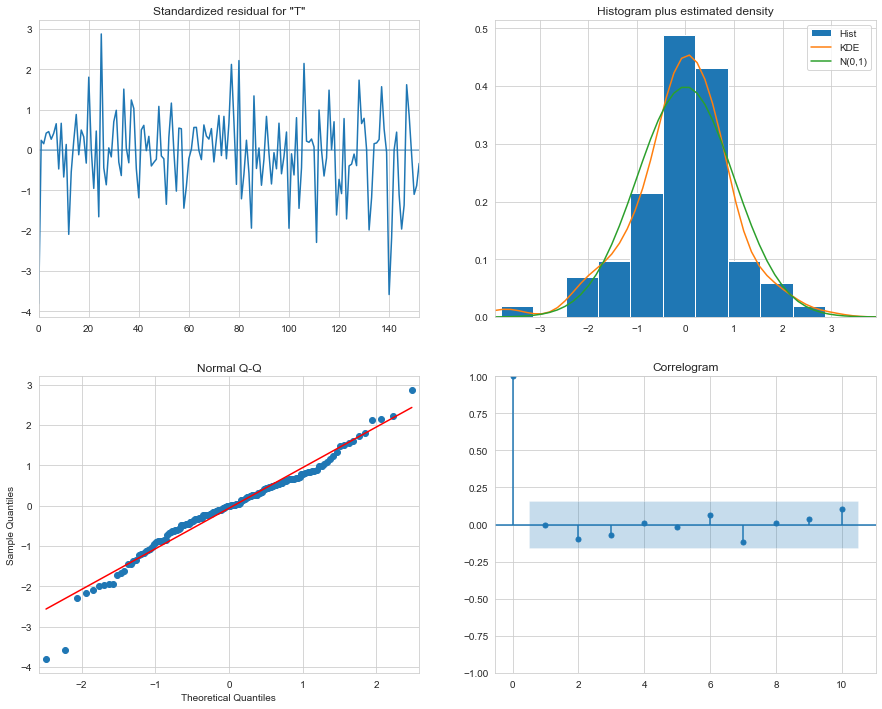

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                       
=============================================================================================
Dep. Variable:                                 Total   No. Observations:                  165
Model:             ARIMA(1, 0, 1)x(0, 1, [1, 2], 12)   Log Likelihood               -1308.019
Date:                               Thu, 23 Feb 2023   AIC                           2628.038
Time:                                       17:08:26   BIC                           2646.220
Sample:                                            0   HQIC                          2635.424
                                               - 165                                         
Covariance Type:                                 opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
covid        -32.2865     23.078     -1.399      0.162     -77.518      12.946
ar.L1          0.9997      0.010     98.713      0.000       0.980       1.020
ma.L1         -0.2206      0.078     -2.818      0.005      -0.374      -0.067
ma.S.L12      -1.0104      0.111     -9.121      0.000      -1.228      -0.793
ma.S.L24       0.0159      0.079      0.203      0.839      -0.138       0.170
sigma2      1.304e+06   7.16e-05   1.82e+10      0.000     1.3e+06     1.3e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                24.03
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.37   Skew:                            -0.50
Prob(H) (two-sided):                  0.27   Kurtosis:                         4.67
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 6.44e+26. Standard errors may be unstable.
"""

In [59]:
best_mod = ARIMA(train["Total"], exog=train["covid"],
                 order=(1, 0, 1), seasonal_order=(0, 1, 2, 12))

best_res = best_mod.fit()

best_res.plot_diagnostics(figsize=(15, 12))
plt.show()
best_res.summary()

In [60]:
train_pred = pd.DataFrame(best_res.fittedvalues, columns=["train_pred"])
train_ci = best_res.get_prediction(dynamic=True).conf_int()

test_forecast = pd.DataFrame(best_res.forecast(steps=19, exog=test["covid"]))

test_ci = best_res.get_forecast(
    steps=19, exog=test["covid"], dynamic=True).conf_int()
ci = pd.concat([train_ci, test_ci], axis=0)

In [61]:
pred = pd.concat([train_pred, test_forecast]).reset_index().drop("index", axis=1)
mod_stats = pd.concat([pred, ci], axis=1)
palau_stats = pd.concat([palau, mod_stats], axis=1)
palau_stats

,Date,JAPAN,SOUTH KOREA,TAIWAN,CHINA,USA/CANADA,EUROPE,OTHERS,Total,covid,train_pred,predicted_mean,lower Total,upper Total
0,2007-06-01,856.0,1291.0,3245.0,86.0,669.0,99.0,463.0,6709.0,0.00000,0.000000,NaN,-6521.254647,6521.254647
1,2007-07-01,2119.0,1366.0,3269.0,33.0,653.0,144.0,437.0,8021.0,0.00000,5265.232382,NaN,-6521.254647,6521.254647
2,2007-08-01,3476.0,1354.0,3046.0,46.0,580.0,256.0,438.0,9196.0,0.00000,6399.000504,NaN,-6521.254647,6521.254647
3,2007-09-01,3022.0,910.0,2497.0,61.0,559.0,145.0,401.0,7595.0,0.00000,7397.893081,NaN,-6521.254647,6521.254647
4,2007-10-01,1807.0,1082.0,2298.0,49.0,774.0,390.0,395.0,6795.0,0.00000,6822.906516,NaN,-6521.254647,6521.254647
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
179,2022-05-01,101.0,16.0,2.0,5.0,541.0,18.0,68.0,751.0,49.73750,NaN,-2966.964035,-9882.358588,3948.430519
180,2022-06-01,62.0,15.0,8.0,10.0,761.0,38.0,93.0,987.0,40.02625,NaN,-1952.405610,-9082.756113,5177.944893
181,2022-07-01,96.0,8.0,15.0,9.0,708.0,127.0,137.0,1100.0,29.84500,NaN,58.973931,-7278.452995,7396.400857
182,2022-08-01,99.0,17.0,82.0,5.0,375.0,133.0,125.0,836.0,25.06625,NaN,1197.947799,-6338.663090,8734.558688


Text(0.5, 1.0, "Palau's Visitor Arrivals")

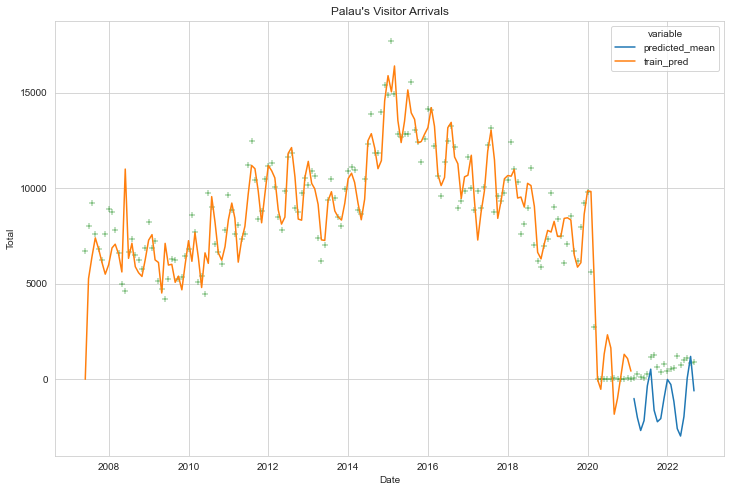

In [62]:
viz_df = palau_stats[["Date", "predicted_mean", "train_pred"]].melt(id_vars=["Date"])
viz_df["Date"] = pd.to_datetime(viz_df["Date"])

plt.figure(figsize=(12,8))
sns.set_style("whitegrid")
sns.scatterplot(x="Date", y="Total", data=palau_stats, color="green", marker="+")
sns.lineplot(data=viz_df, x="Date", y="value", hue="variable")
plt.title("Palau's Visitor Arrivals")